# Grover's Algorithm Quantum Circuit Evolution Notebook

This notebook implements a grammatical evolution (GE) approach to design quantum circuits for Grover's algorithm. The notebook uses Qiskit for quantum circuit simulation, DEAP for evolutionary computation, and a custom library (`grape`) for grammatical evolution.

The main objectives are:
- To evolve quantum circuits using GE.
- To simulate and evaluate the performance of these circuits.
- To log and visualize the evolution process and results.

## 1. Setup and Configuration

In this section, we import all necessary libraries, set up the working directory, and configure the environment (e.g., suppress warnings and set a random seed). All imports are grouped by standard library, third-party libraries, and local modules.

In [1]:
# Standard Library Imports
import os
import re
import json
import random
import multiprocessing
from typing import Any, Tuple

# Third-party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import QuantumCircuit, transpile
from qiskit_aer import QasmSimulator
from qiskit.visualization import plot_histogram
from IPython.display import display
from deap import creator, base, tools


import grape  # Grammatical evolution library
from grape import algorithms  # Evolutionary algorithms

In [2]:
# Get the number of logical CPU cores available
num_cores = os.cpu_count()
print("Number of CPU cores available:", num_cores)

Number of CPU cores available: 8


## 2. Grammar and Data Path Configuration

We define the path to our data directory and the grammar file used for grammatical evolution. The grammar is loaded using the `grape` library.

In [3]:
BNF_GRAMMAR = grape.Grammar("grammars/grover.bnf")

In [4]:
SEED = 2526
random.seed(SEED)
np.random.seed(SEED)

## 3. Oracle Generation

The `generate_oracle_for_state` function generates the Grover oracle code for a given marked state. This code is later injected into the circuit phenotype.

In [5]:
def generate_oracle_for_state(marked_state: str) -> str:
    """Generate Grover oracle code for a given marked state."""
    n = len(marked_state)
    code_lines = []
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    code_lines.append(f"qc.h({n-1})")
    code_lines.append(f"qc.mcx(list(range({n-1})), {n-1})")
    code_lines.append(f"qc.h({n-1})")
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    return "\n".join(code_lines) + "\n"

## 4. CircuitEvaluator Class

The `CircuitEvaluator` class encapsulates several key tasks:
- **Decoding** an individual's genome to retrieve the phenotype code.
- **Executing** the phenotype code to produce a `QuantumCircuit`.
- **Simulating** the circuit to obtain performance metrics.
- **Logging** evaluation details to JSON and CSV files.

This modular design improves maintainability and reusability of the code.

In [6]:
class CircuitEvaluator:
    def __init__(self, shots: int = 512, log_dir: str = "logs"):
        """
        Initialize the evaluator with simulation parameters and logging directory.
        """
        self.shots = shots
        self.log_dir = log_dir
        os.makedirs(self.log_dir, exist_ok=True)
    
    def decode_individual(self, ind) -> str:
        """
        Decodes an individual's genome into a phenotype code string.
        Returns:
            A string containing the code if decoding is successful,
            or None if invalid.
        """
        if ind.invalid or not hasattr(ind, 'phenotype'):
            return None
        try:
            phenotype_code = ind.phenotype
            if isinstance(phenotype_code, list):
                phenotype_code = "".join(phenotype_code)
            # Replace literal \n with actual newlines and clean quotes
            cleaned_code = re.sub(r'\\n', '\n', phenotype_code)
            cleaned_code = re.sub(r'^"|"$', '', cleaned_code)
            cleaned_code = re.sub(r'"\s+"', '\n', cleaned_code)
            return cleaned_code
        except Exception as ex:
            print(f"[Decode Error] {ex}")
            return None
    
    def execute_circuit(self, phenotype_code: str) -> QuantumCircuit:
        """
        Executes the phenotype code to produce a QuantumCircuit.
        Returns:
            The QuantumCircuit if 'qc' is found in the execution context,
            otherwise None.
        """
        local_vars = {}
        try:
            exec(phenotype_code, globals(), local_vars)
            if "qc" in local_vars:
                return local_vars["qc"]
            else:
                print("No circuit variable 'qc' found in phenotype code.")
                return None
        except Exception as e:
            print(f"Error executing phenotype code: {e}")
            return None
    
    def simulate_circuit(self, circuit: QuantumCircuit, marked_state: str) -> dict:
        """
        Simulates the circuit and returns performance metrics for the given marked state.
        
        Args:
            circuit (QuantumCircuit): The circuit to simulate.
            marked_state (str): The state to evaluate.
        
        Returns:
            dict: Contains counts, p_marked, error, gate_count, and depth.
        """
        simulator = QasmSimulator()
        compiled = transpile(circuit, simulator, optimization_level=0)
        result = simulator.run(compiled, shots=self.shots).result()
        counts = result.get_counts()
        # Reverse bitstrings to match the expected format.
        corrected = {k[::-1]: v for k, v in counts.items()}
        total = sum(corrected.values())
        p_marked = corrected.get(marked_state, 0) / total if total > 0 else 0.0
        error = 1 - p_marked
        return {
            "counts": corrected,
            "p_marked": p_marked,
            "error": error,
            "gate_count": compiled.size(),
            "depth": compiled.depth()
        }
    
    def log_evaluation(self, logs: list, generation: int, individual) -> None:
        """
        Logs the evaluation details for an individual to JSON and CSV files.
        """
        id_hash = hash(str(individual.genome)) % 10**8
        log_file_json = os.path.join(self.log_dir, f"eval_gen{generation}_id{id_hash}.json")
        log_file_csv = os.path.join(self.log_dir, f"eval_gen{generation}_id{id_hash}.csv")
        with open(log_file_json, "w") as f:
            json.dump(logs, f, indent=2)
        df = pd.DataFrame(logs)
        df[["state", "p_marked", "error", "gate_count", "depth"]].to_csv(log_file_csv, index=False)

## 5. Oracle Injection

The `inject_oracle` function is used to inject the generated oracle code into the phenotype code at a designated marker.

In [7]:
def inject_oracle(phenotype_str: str, oracle_code: str) -> str:
    """Inject oracle code into the phenotype string."""
    pattern = r"(## Begin Oracle\n)(.*?)(## End Oracle\n)"
    new_block = r"\1" + oracle_code + r"\3"
    return re.sub(pattern, new_block, phenotype_str, flags=re.DOTALL)

## 6. Fitness Function

The `fitness_function` evaluates the performance of the quantum circuit represented by the phenotype. It does so by:
- Injecting the oracle for each possible marked state.
- Executing and simulating the circuit using the methods in `CircuitEvaluator`.
- Applying penalties for errors, high gate counts, and circuit depth.
- Calculating a final fitness score and logging detailed state performance if required.

In [8]:
# def fitness_function(
#     phenotype_str,
#     shots=512,
#     miss_threshold=0.70,      # 1) Below this, count a miss
#     bonus_threshold=0.70,     # 2) Target success probability for bonus/reward
#     zero_prob_penalty=10.0,   # 3) Additional penalty if there's at least one miss
#     gate_penalty_weight=0.01, # 4) Weighting factor for average gate count penalty
#     p_penalty_weight=20.0,    # 5) Penalty weight for states below bonus_threshold
#     bonus_weight=5.0,         # 6) Reward weight for states above bonus_threshold
#     log_states=False
# ):
#     """
#     Evaluates an evolved Grover circuit using a lexicographic scheme:
#       1. 10 × (number of misses) -- a miss is when p(marked) < miss_threshold.
#       2. Maximum error (1 - p_marked) among all states.
#       3. Gate penalty proportional to the average gate count.
#       4. Additional penalty for states below bonus_threshold.
#       5. Bonus (reward) for states above bonus_threshold.
#       6. Optionally, a zero probability penalty if any miss occurs.
#     """
#     num_qubits = 3
#     all_states = [format(i, f"0{num_qubits}b") for i in range(2**num_qubits)]
    
#     evaluator = CircuitEvaluator(shots=shots)
#     logs = []

#     total_misses = 0
#     max_error = 0.0
#     gate_counts = []
    
#     extra_penalty = 0.0  # Cumulative penalty for states with p_marked below bonus_threshold
#     bonus_term = 0.0     # Cumulative bonus for states with p_marked above bonus_threshold

#     for marked_state in all_states:
#         oracle_code = generate_oracle_for_state(marked_state)
#         modified_code = inject_oracle(phenotype_str, oracle_code)
#         qc = evaluator.execute_circuit(modified_code)
#         if qc is None:
#             continue

#         result = evaluator.simulate_circuit(qc, marked_state)
#         p_marked = result["p_marked"]
#         error = 1 - p_marked  # Error for this state
#         max_error = max(max_error, error)
#         gate_count = result["gate_count"]
#         gate_counts.append(gate_count)
    
#         if p_marked < miss_threshold:
#             total_misses += 1

#         # Apply penalty if below bonus_threshold; reward if above.
#         if p_marked < bonus_threshold:
#             extra_penalty += p_penalty_weight * (bonus_threshold - p_marked)
#         else:
#             bonus_term += bonus_weight * (p_marked - bonus_threshold)

#         if log_states:
#             logs.append({
#                 "state": marked_state,
#                 "p_marked": p_marked,
#                 "error": error,
#                 "gate_count": gate_count,
#                 "depth": result.get("depth", None),
#                 "counts": result["counts"],
#                 "oracle": oracle_code,
#                 "code": modified_code
#             })

#     avg_gate_count = np.mean(gate_counts) if gate_counts else 0
#     gate_penalty = gate_penalty_weight * avg_gate_count
#     zero_prob_penalty_term = zero_prob_penalty if total_misses > 0 else 0.0

#     # Final fitness: lower is better.
#     raw_fitness_score = (
#         10 * total_misses +  # Heavy penalty for misses
#         max_error +          # Maximum error among states
#         gate_penalty +       # Penalty for gate count
#         zero_prob_penalty_term +
#         extra_penalty -      # Additional penalty for low p_marked states
#         bonus_term          # Bonus reward for high p_marked states
#     )
    
#     # Clamp fitness score to be non-negative.
#     fitness_score = max(raw_fitness_score, 0.0)

#     return (fitness_score, logs) if log_states else fitness_score

def fitness_function(
    phenotype_str,
    shots=512,
    threshold=0.48,   # A miss occurs if error (1 - p_marked) > 0.48
    log_states=False
):
    """
    Evaluates an evolved Grover circuit using a lexicographic scheme:
      Fitness = 10 × (number of misses) + (maximum error among all test cases)
    A "miss" is defined as a test case where the probability of error (1 - p_marked)
    is greater than the given threshold (0.48). This scheme prioritizes reducing the 
    number of misses over reducing the maximum error.
    
    Returns:
        fitness (float), and optionally log_per_state (list of dicts) if log_states is True.
    """
    num_qubits = 3
    all_states = [format(i, f"0{num_qubits}b") for i in range(2**num_qubits)]
    evaluator = CircuitEvaluator(shots=shots)
    logs = []
    
    number_of_misses = 0
    max_error = 0.0
    
    for marked_state in all_states:
        oracle_code = generate_oracle_for_state(marked_state)
        modified_code = inject_oracle(phenotype_str, oracle_code)
        qc = evaluator.execute_circuit(modified_code)
        if qc is None:
            continue
        
        result = evaluator.simulate_circuit(qc, marked_state)
        p_marked = result["p_marked"]
        error = 1 - p_marked
        
        # Count a miss if error is greater than the threshold.
        if error > threshold:
            number_of_misses += 1
        
        max_error = max(max_error, error)
        
        if log_states:
            logs.append({
                "state": marked_state,
                "p_marked": p_marked,
                "error": error,
                "oracle": oracle_code,
                "code": modified_code,
                "counts": result["counts"],
                "gate_count": result.get("gate_count", None),
                "depth": result.get("depth", None)
            })
    
    # Lexicographic fitness: number_of_misses is heavily penalized (10x) over maximum error.
    fitness_score = 10 * number_of_misses + max_error
    
    return (fitness_score, logs) if log_states else fitness_score

## 7. Visualization Functions

This section contains functions to create visualizations, such as the success probability heatmap for the different 3-bit states and histograms of measurement counts.

In [9]:
def plot_success_heatmap(log_per_state):
    """
    Creates a heatmap of p(marked) across all 3-bit states.
    """
    data = {log["state"]: log["p_marked"] for log in log_per_state}
    matrix = np.zeros((2, 4))  # 3 qubits → 8 states → shape (2, 4)

    for state, prob in data.items():
        row = int(state[0], 2)
        col = int(state[1:], 2)
        matrix[row, col] = prob

    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, annot=True, cmap="YlGnBu", cbar=True, vmin=0, vmax=1)
    plt.title("Success Probability Heatmap")
    plt.xlabel("State bits q1q2")
    plt.ylabel("State bit q0")
    plt.xticks(np.arange(4)+0.5, ['00','01','10','11'])
    plt.yticks(np.arange(2)+0.5, ['0','1'], rotation=0)
    plt.show()

## 8. GE Parameters and Toolbox Setup

Here, we define the parameters for the evolutionary algorithm and initialize the DEAP toolbox. This includes setting population size, mutation rates, selection methods, and creating the fitness and individual classes.

In [10]:
# Define GE parameters
POPULATION_SIZE    = 1000
MAX_GENERATIONS    = 100
N_GEN = 1
P_CROSSOVER        = 0.8     
P_MUTATION         = 0.01
ELITE_SIZE         = 1
HALLOFFAME_SIZE    = 1
CODON_SIZE         = 400
MAX_TREE_DEPTH     = 50      
TOURNAMENT_SIZE    = 5
MIN_INIT_DEPTH     = 20        
MAX_INIT_DEPTH     = 40       
CODON_CONSUMPTION  = "lazy"   
GENOME_REPRESENTATION='list'
REPORT_ITEMS = ['gen', 'invalid', 'avg', 'std', 'min', 'max',
                'fitness_test',
                'best_ind_length', 'avg_length',
                'best_ind_nodes', 'avg_nodes',
                'avg_depth',
                'avg_used_codons', 'best_ind_used_codons',
                'selection_time', 'generation_time']

In [11]:
# Create fitness and individual classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)

# Initialize toolbox
toolbox = base.Toolbox()
toolbox.register(
    "populationCreator",
    grape.sensible_initialisation,
    creator.Individual,
    bnf_grammar=BNF_GRAMMAR,
    min_init_depth=MIN_INIT_DEPTH,  
    max_init_depth=MAX_INIT_DEPTH,  
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION,
)
toolbox.register("mate", grape.crossover_onepoint)
toolbox.register("mutate", grape.mutation_int_flip_per_codon)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)
# Create a pool of worker processes (using the number of available cores)
pool = multiprocessing.Pool(8)

# Register the pool's map function with the DEAP toolbox
toolbox.register("map", pool.map)

In [12]:
LOG_DIR = "logs"
os.makedirs(LOG_DIR, exist_ok=True)

def evaluate(individual: Any, points_train=None) -> Tuple[float]:
    evaluator = CircuitEvaluator(shots=512, log_dir=LOG_DIR)
    phenotype_str = evaluator.decode_individual(individual)
    if not phenotype_str:
        return (float('inf'),)
    
    # Using the existing fitness_function with log_states=True.
    fitness_val, logs = fitness_function(phenotype_str, log_states=True)

    if fitness_val < float('inf'):
        gen = getattr(individual, "generation", "unknown")
        evaluator.log_evaluation(logs, gen, individual)

    return (fitness_val,)
toolbox.register("evaluate", evaluate)


## 9. Evolutionary Loop and Evaluation

The main evolution loop runs for a predefined number of generations. At each generation:
- The population is evolved using elitism.
- The best individual is visualized.
- The circuit's performance is evaluated and logged using the `CircuitEvaluator` class.

After the evolution, the best individuals (Hall of Fame) are displayed and further evaluated.

gen = 0 , Best fitness = (60.5078125,)
gen = 1 , Best fitness = (50.51171875,) , Number of invalids = 169


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 0] Best Fitness: 50.5117


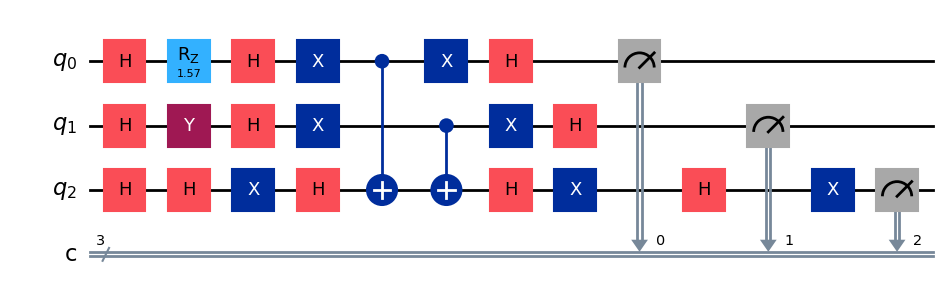

gen = 0 , Best fitness = (50.51171875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (50.51171875,) , Number of invalids = 128


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 1] Best Fitness: 50.5117


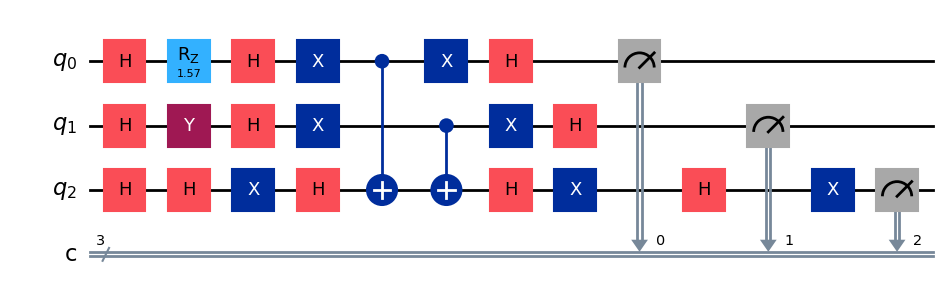

gen = 0 , Best fitness = (50.51171875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (50.51171875,) , Number of invalids = 105


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 2] Best Fitness: 50.5117


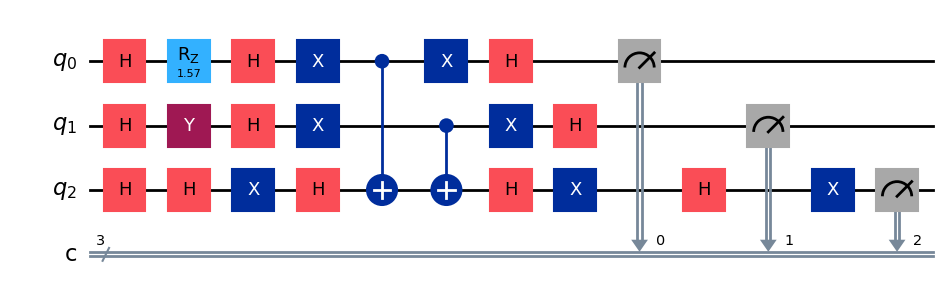

gen = 0 , Best fitness = (50.51171875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (40.53125,) , Number of invalids = 82


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 3] Best Fitness: 40.5312


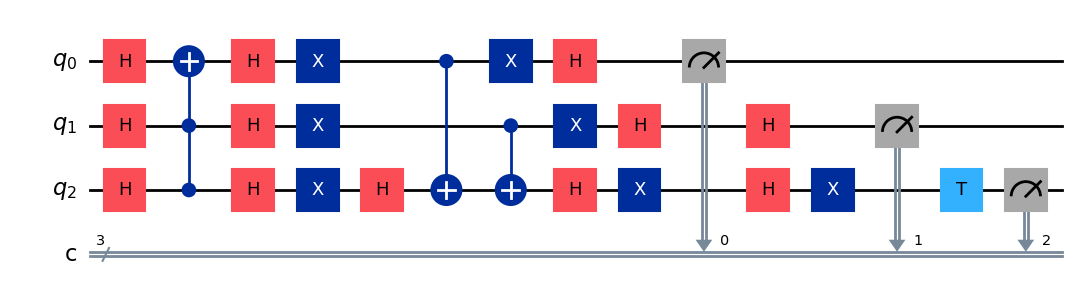

gen = 0 , Best fitness = (40.53125,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (30.509765625,) , Number of invalids = 79


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 4] Best Fitness: 30.5098


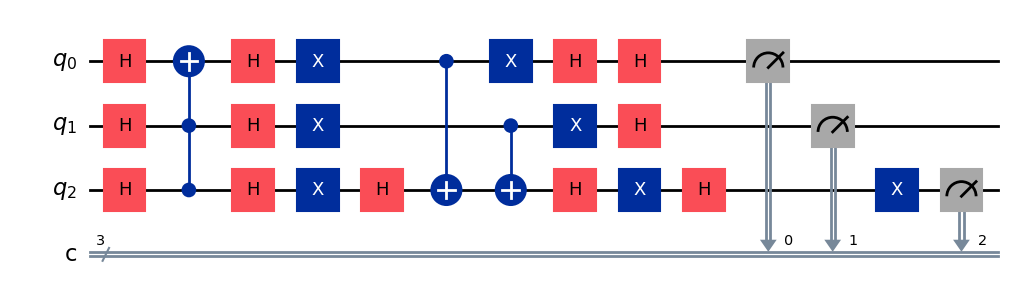

gen = 0 , Best fitness = (30.509765625,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (30.509765625,) , Number of invalids = 70


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 5] Best Fitness: 30.5098


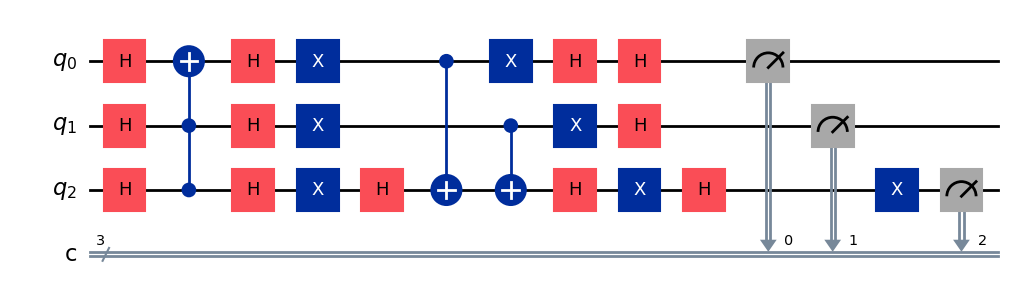

gen = 0 , Best fitness = (30.509765625,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (30.509765625,) , Number of invalids = 75


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 6] Best Fitness: 30.5098


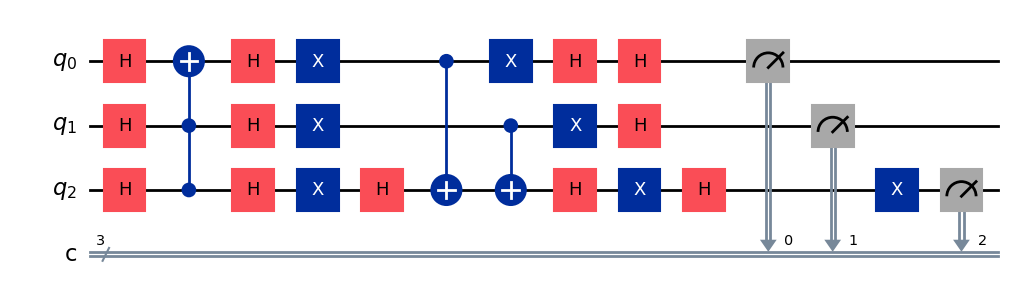

gen = 0 , Best fitness = (30.509765625,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (30.509765625,) , Number of invalids = 64


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 7] Best Fitness: 30.5098


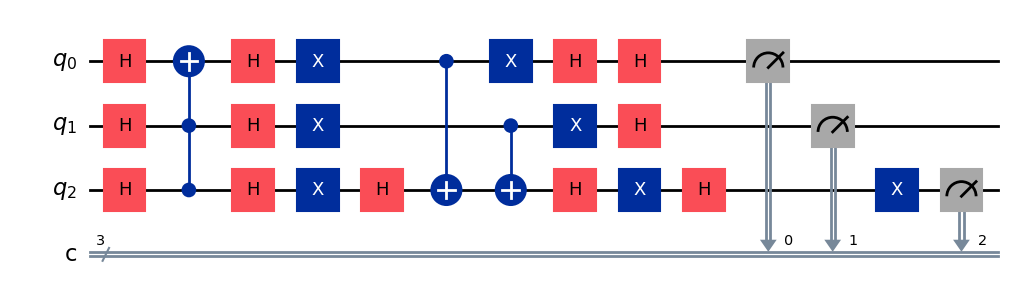

gen = 0 , Best fitness = (30.509765625,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (30.509765625,) , Number of invalids = 83


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 8] Best Fitness: 30.5098


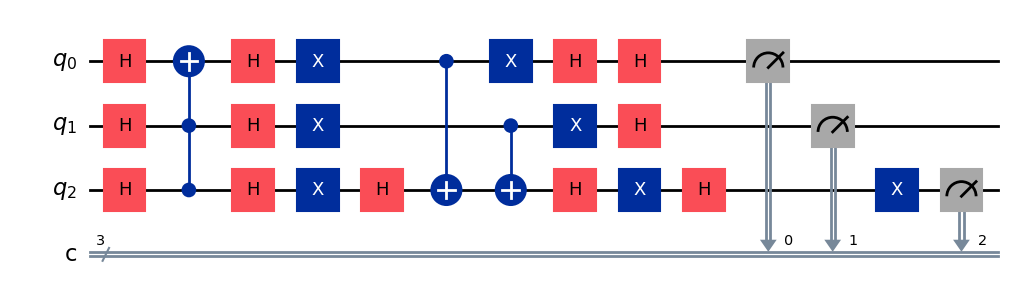

gen = 0 , Best fitness = (30.509765625,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (30.509765625,) , Number of invalids = 50


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 9] Best Fitness: 30.5098


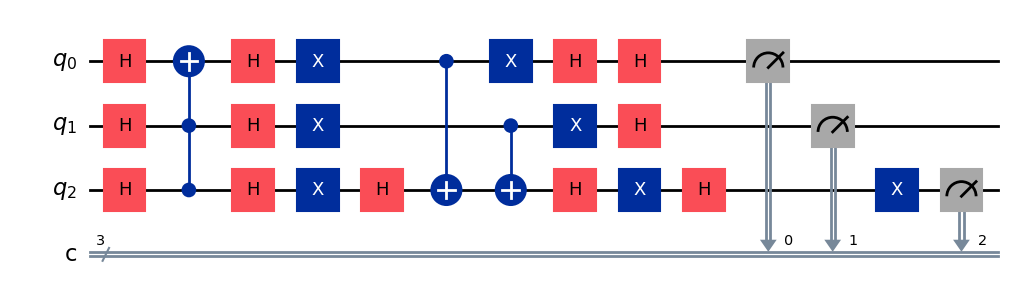

gen = 0 , Best fitness = (30.509765625,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (30.509765625,) , Number of invalids = 51


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 10] Best Fitness: 30.5098


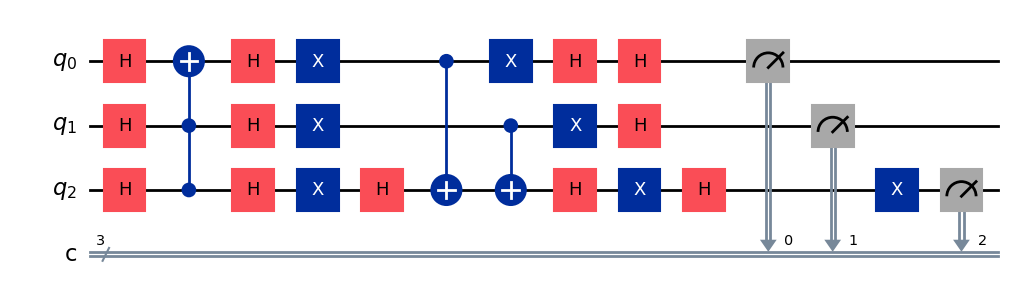

gen = 0 , Best fitness = (30.509765625,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (30.5,) , Number of invalids = 33


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 11] Best Fitness: 30.5000


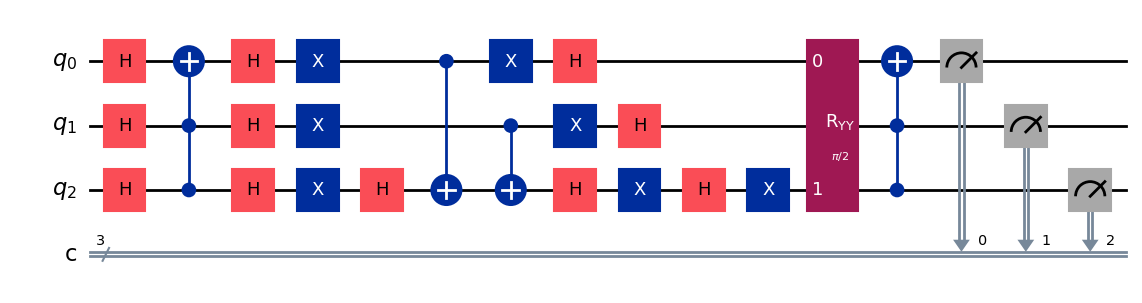

gen = 0 , Best fitness = (30.5,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (30.5,) , Number of invalids = 20


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 12] Best Fitness: 30.5000


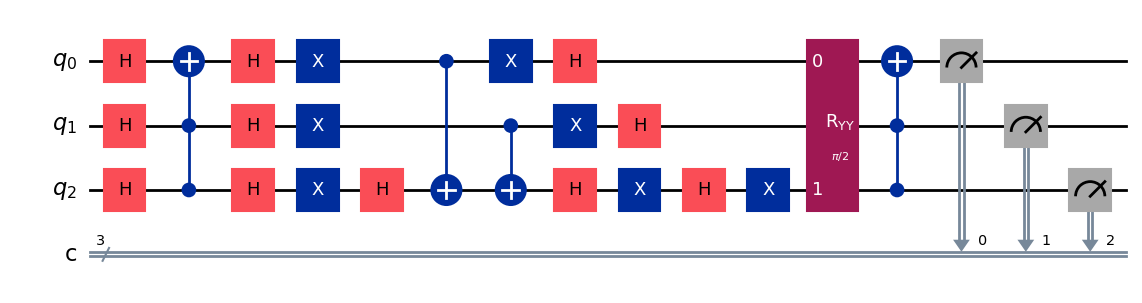

gen = 0 , Best fitness = (30.5,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (30.5,) , Number of invalids = 17


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 13] Best Fitness: 30.5000


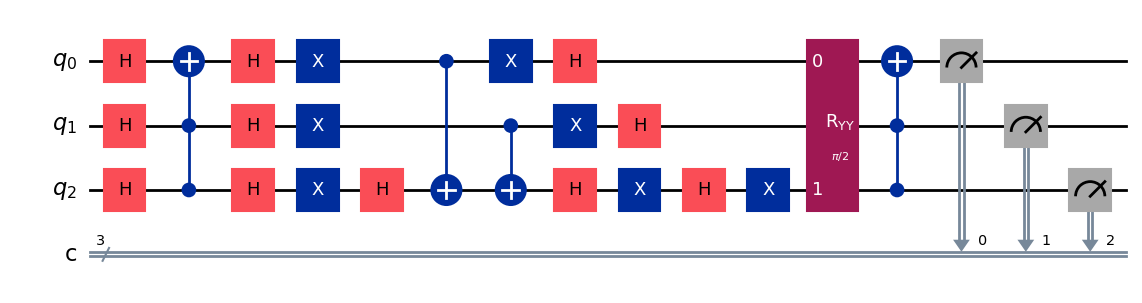

gen = 0 , Best fitness = (30.5,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (30.5,) , Number of invalids = 18


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 14] Best Fitness: 30.5000


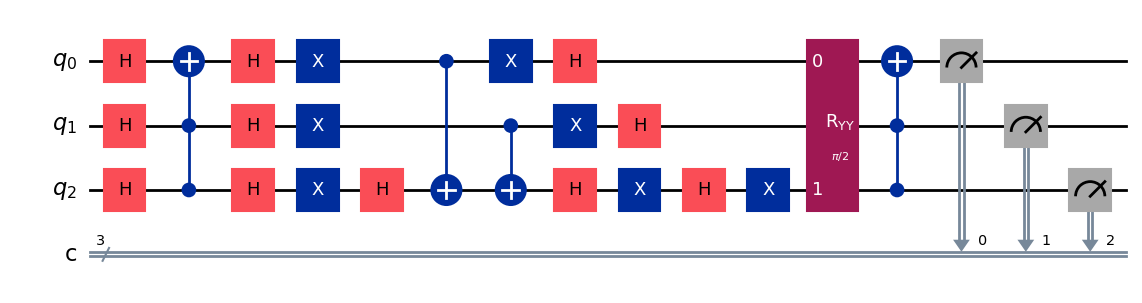

gen = 0 , Best fitness = (30.5,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (30.5,) , Number of invalids = 5


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 15] Best Fitness: 30.5000


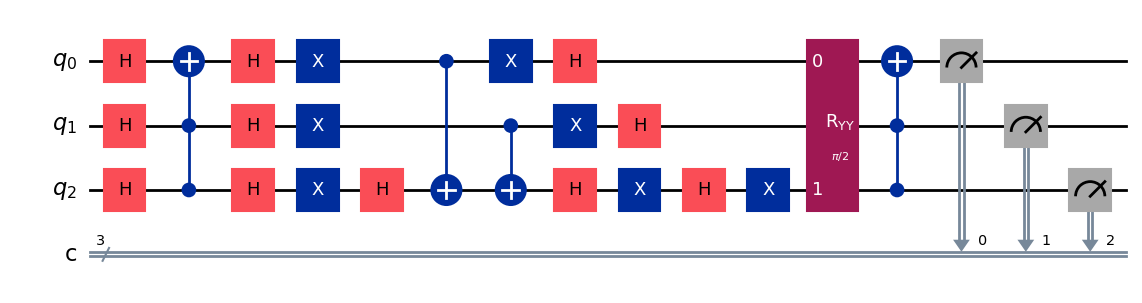

gen = 0 , Best fitness = (30.5,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (30.5,) , Number of invalids = 4


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 16] Best Fitness: 30.5000


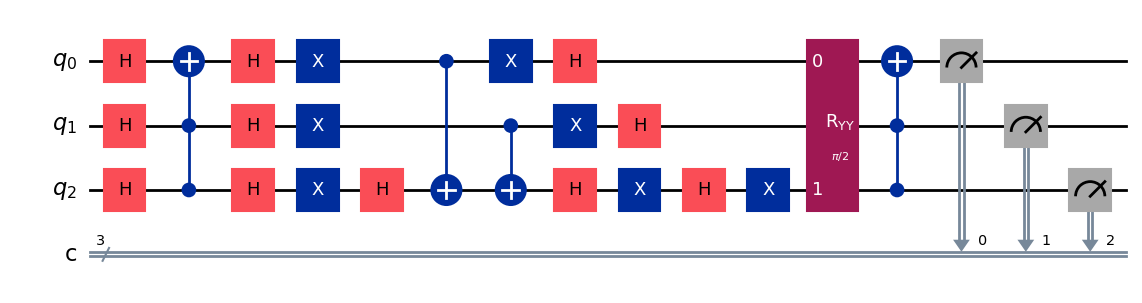

gen = 0 , Best fitness = (30.5,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 8


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 17] Best Fitness: 20.5137


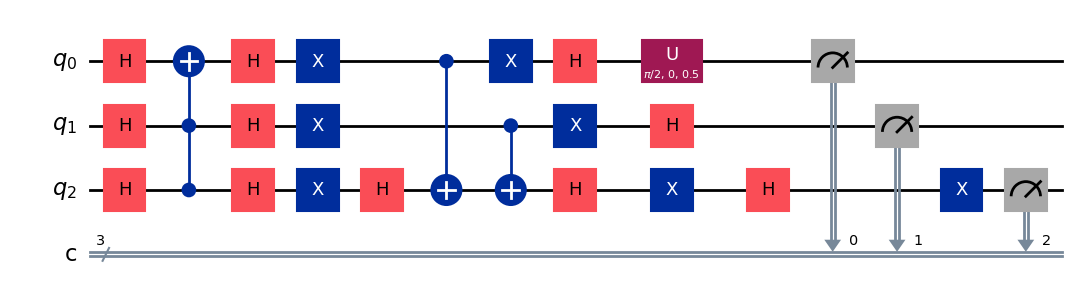

gen = 0 , Best fitness = (20.513671875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 5


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 18] Best Fitness: 20.5137


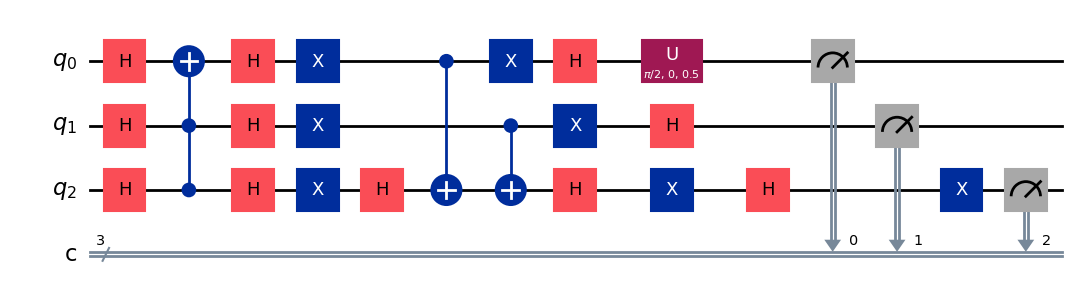

gen = 0 , Best fitness = (20.513671875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 10


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 19] Best Fitness: 20.5137


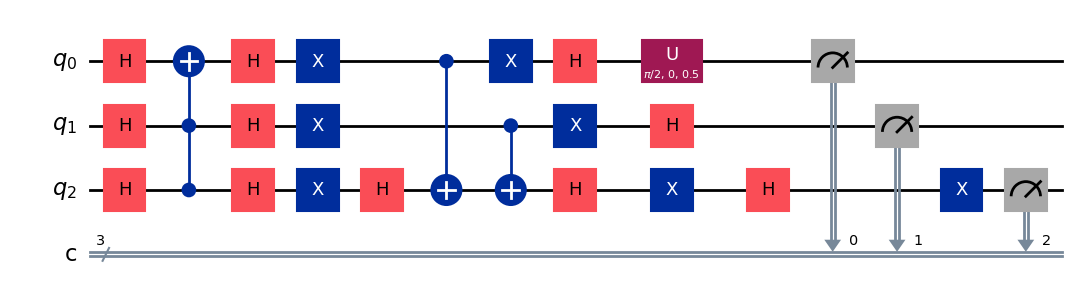

gen = 0 , Best fitness = (20.513671875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 2


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 20] Best Fitness: 20.5137


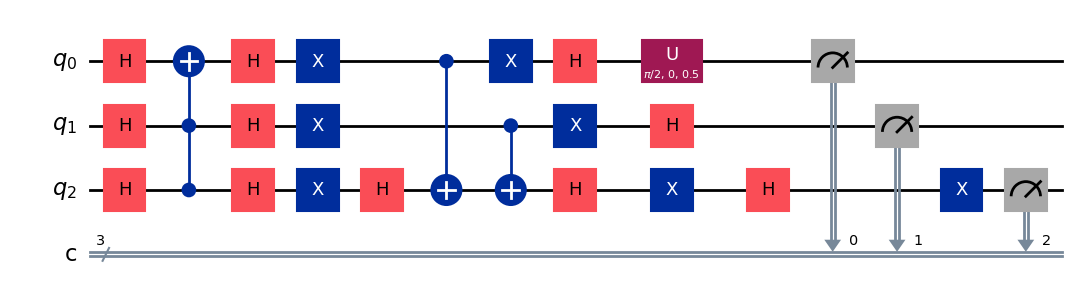

gen = 0 , Best fitness = (20.513671875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 3


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 21] Best Fitness: 20.5137


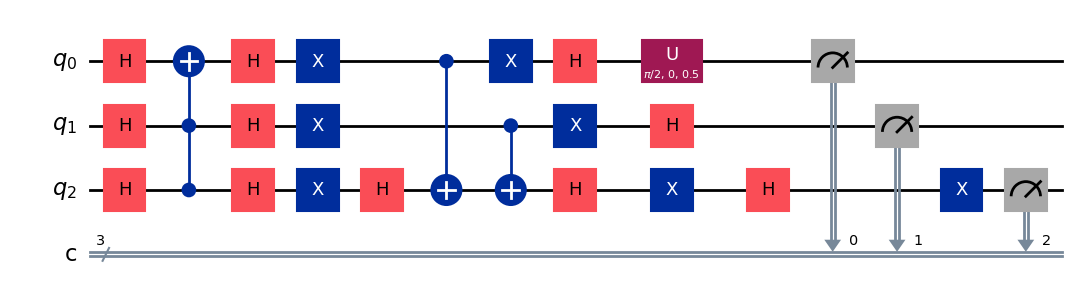

gen = 0 , Best fitness = (20.513671875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 3


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 22] Best Fitness: 20.5137


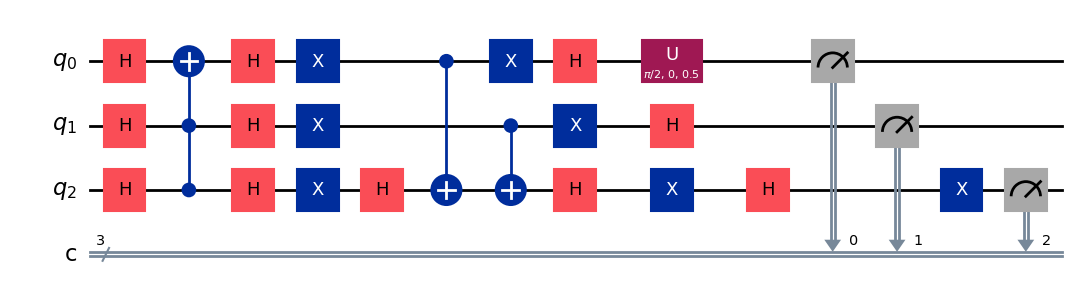

gen = 0 , Best fitness = (20.513671875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 23] Best Fitness: 20.5137


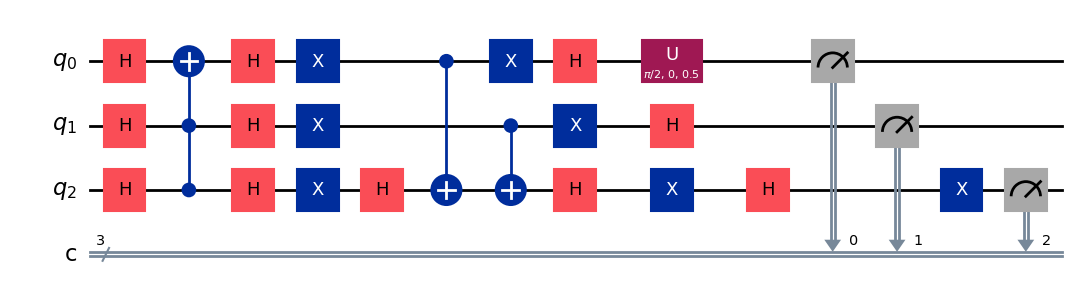

gen = 0 , Best fitness = (20.513671875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 24] Best Fitness: 20.5137


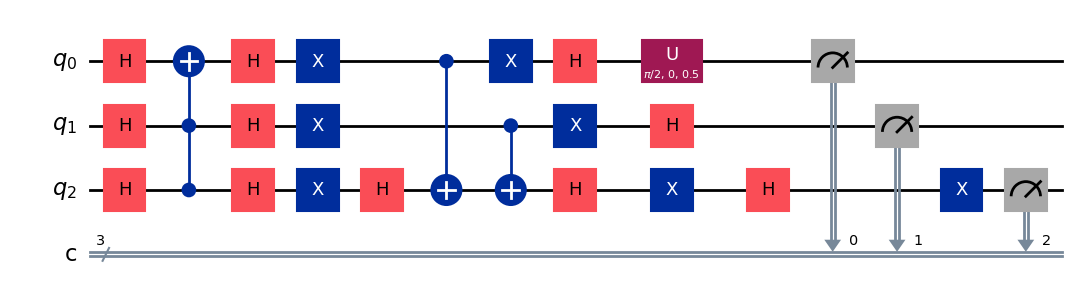

gen = 0 , Best fitness = (20.513671875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 2


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 25] Best Fitness: 20.5137


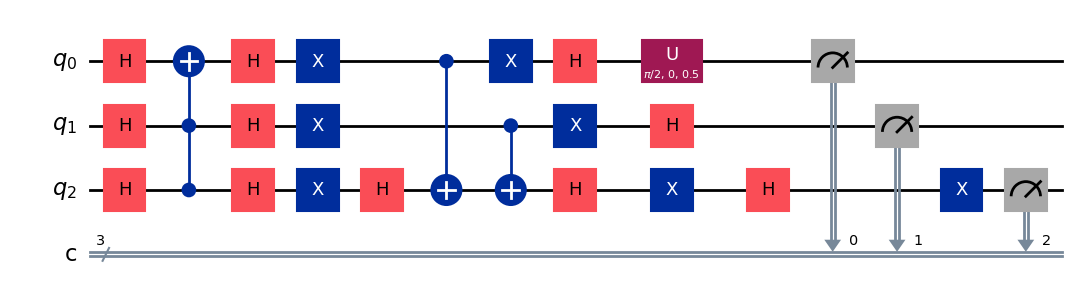

gen = 0 , Best fitness = (20.513671875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 4


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 26] Best Fitness: 20.5137


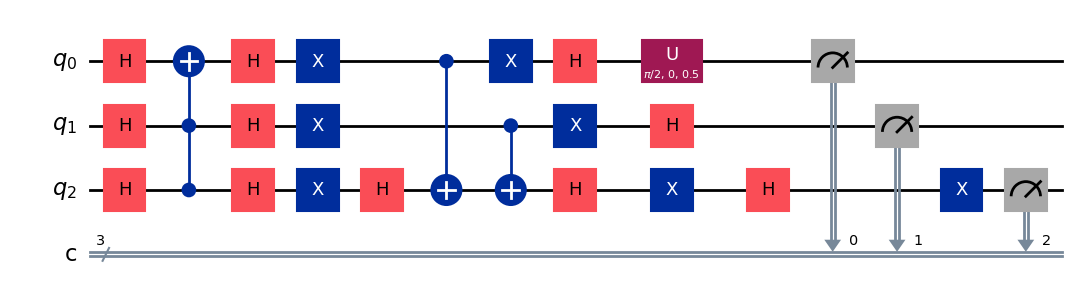

gen = 0 , Best fitness = (20.513671875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 3


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 27] Best Fitness: 20.5137


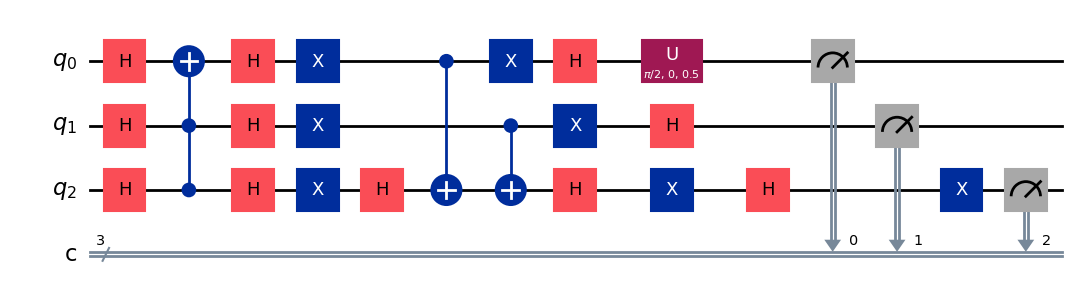

gen = 0 , Best fitness = (20.513671875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 28] Best Fitness: 20.5137


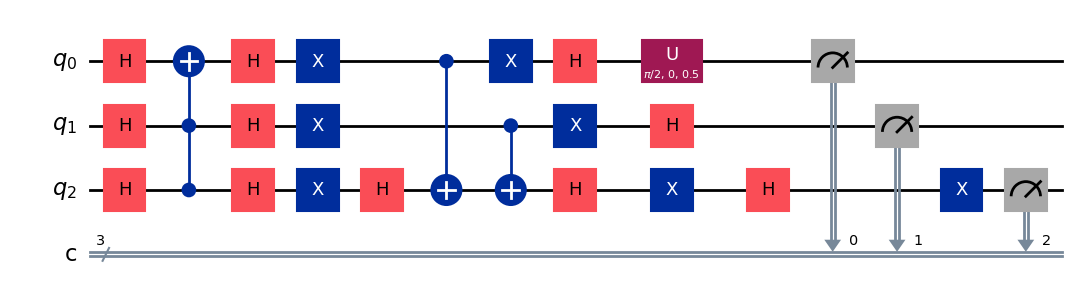

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 29] Best Fitness: 20.5137


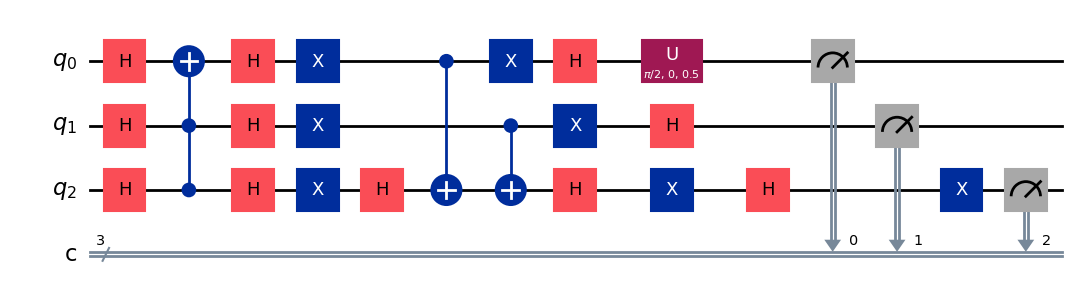

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 7


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 30] Best Fitness: 20.5137


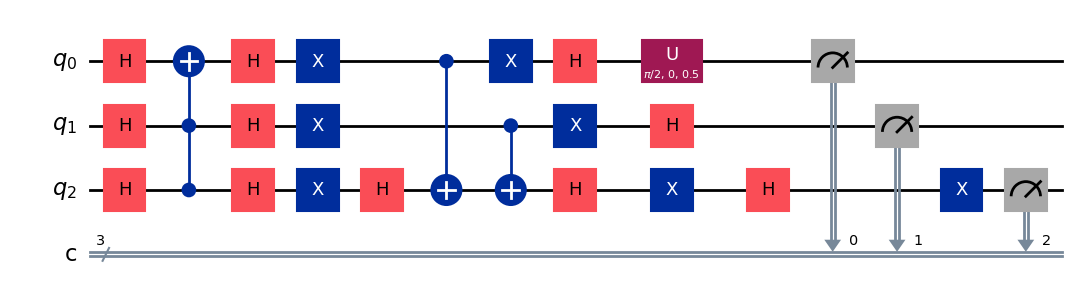

gen = 0 , Best fitness = (20.513671875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 31] Best Fitness: 20.5137


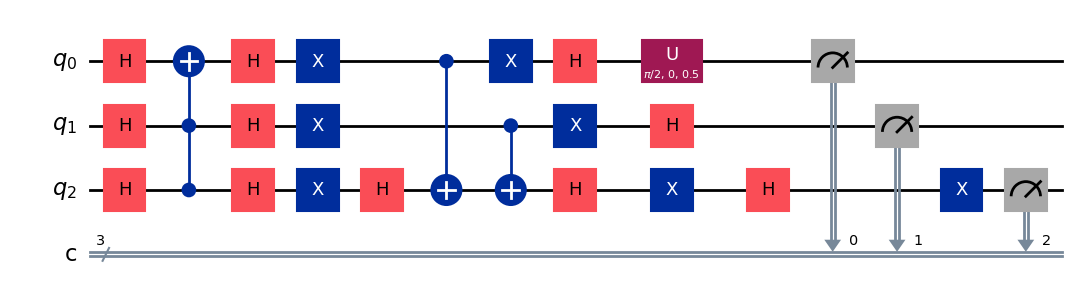

gen = 0 , Best fitness = (20.513671875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 4


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 32] Best Fitness: 20.5137


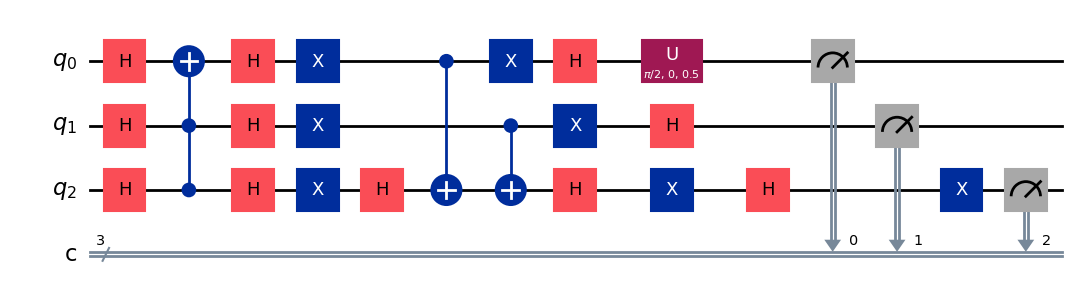

gen = 0 , Best fitness = (20.513671875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 33] Best Fitness: 20.5137


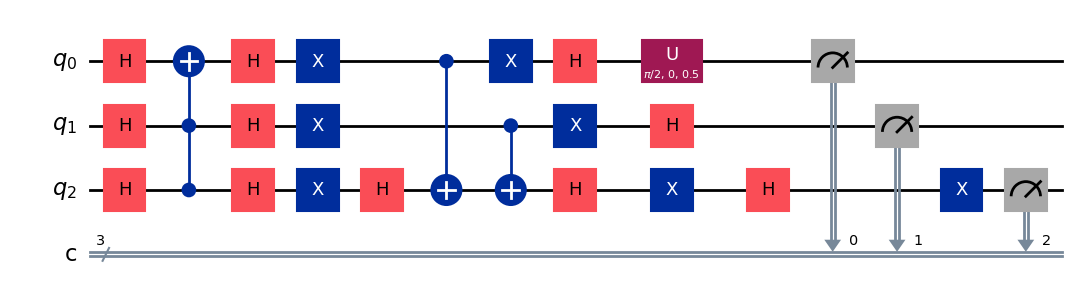

gen = 0 , Best fitness = (20.513671875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 34] Best Fitness: 20.5137


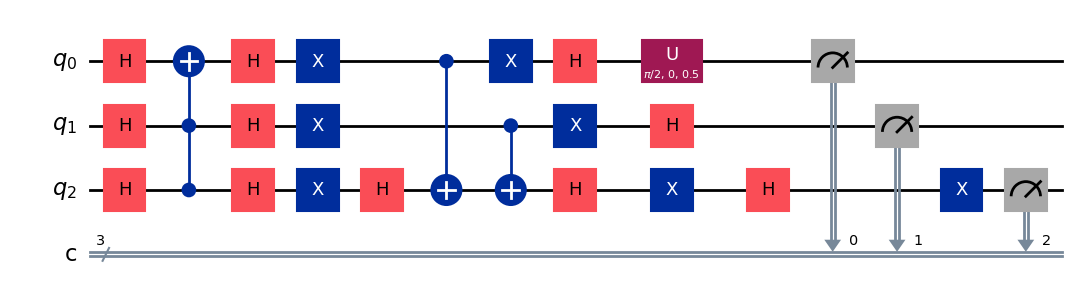

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 35] Best Fitness: 20.5137


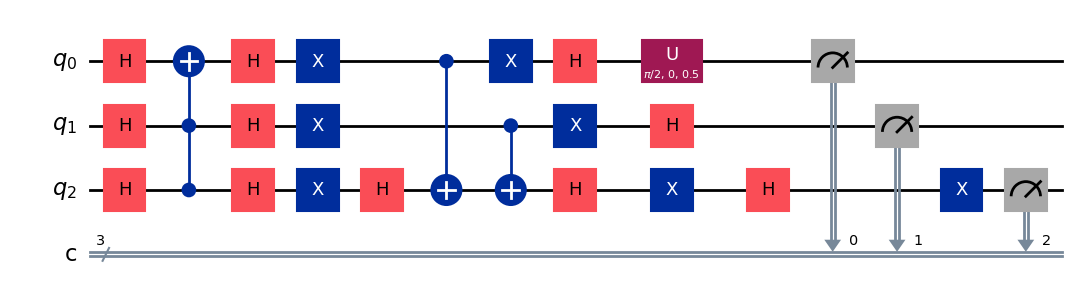

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 2


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 36] Best Fitness: 20.5137


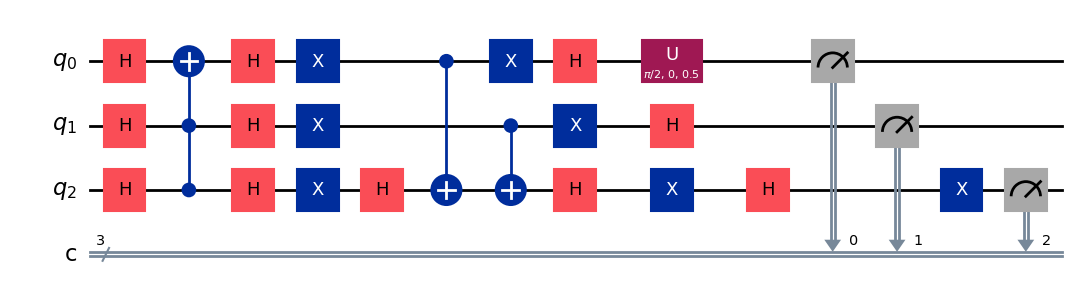

gen = 0 , Best fitness = (20.513671875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 37] Best Fitness: 20.5137


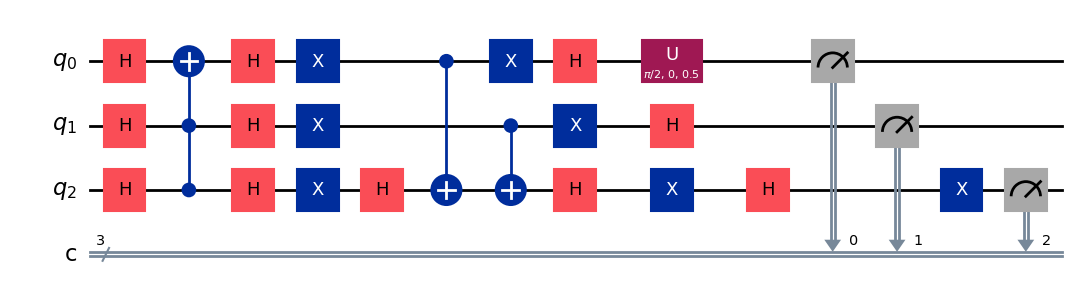

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 38] Best Fitness: 20.5137


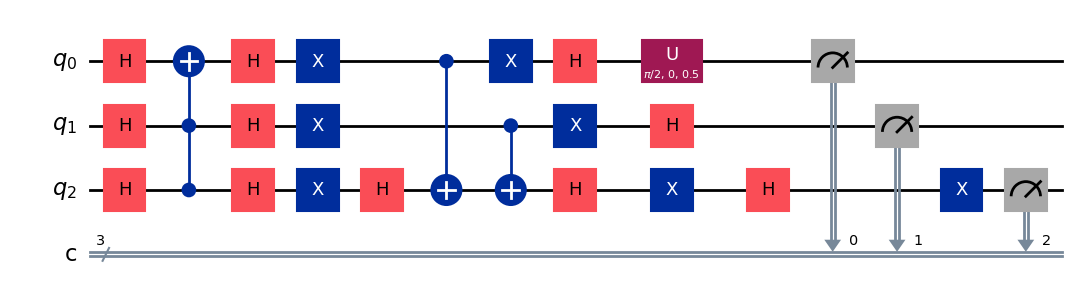

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 39] Best Fitness: 20.5137


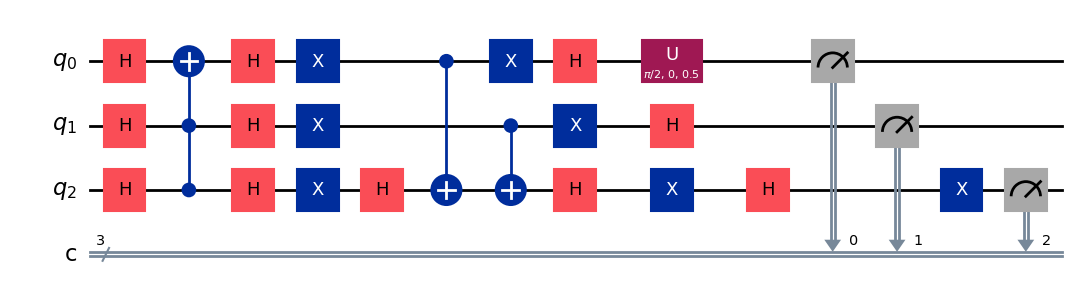

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 40] Best Fitness: 20.5137


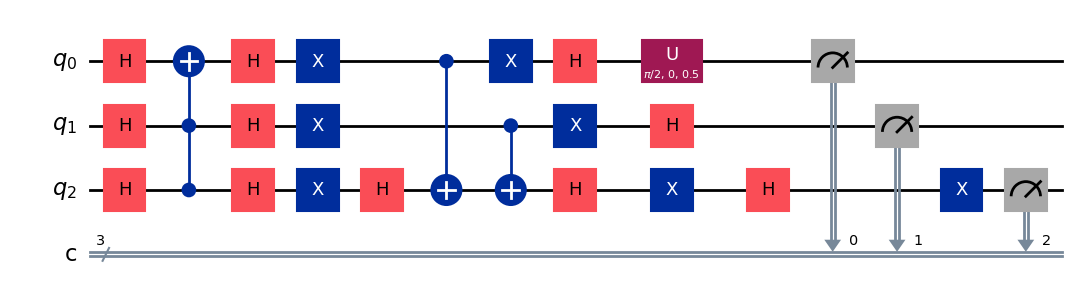

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 41] Best Fitness: 20.5137


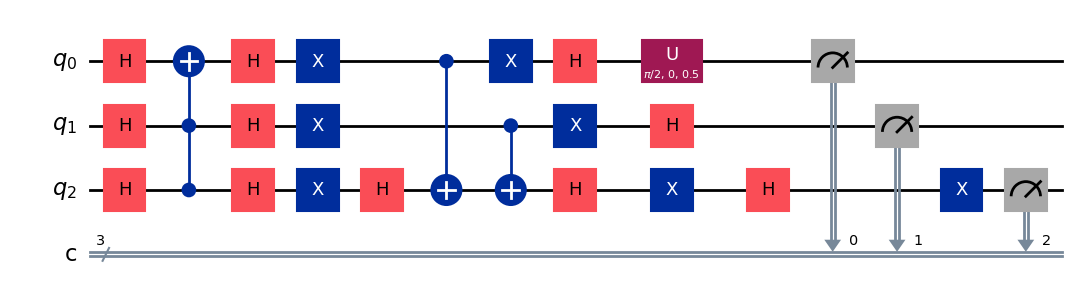

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 42] Best Fitness: 20.5137


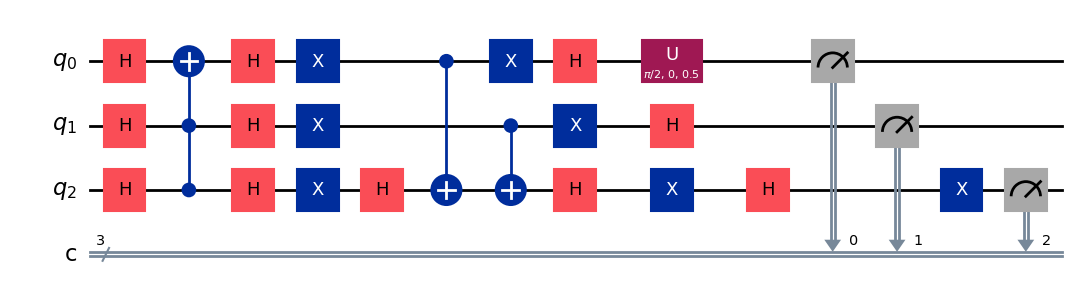

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 43] Best Fitness: 20.5137


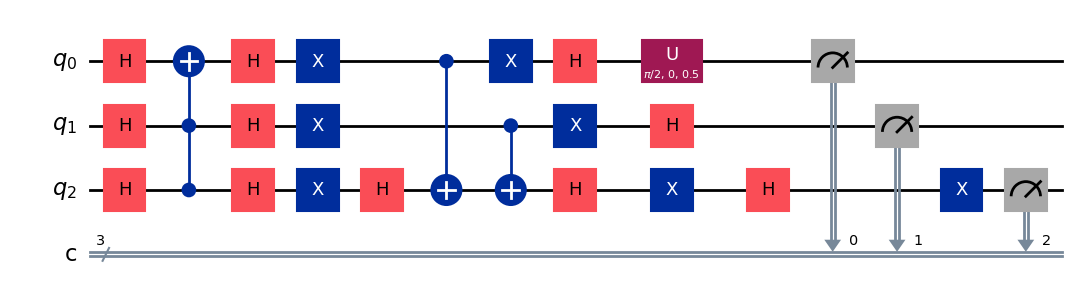

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 44] Best Fitness: 20.5137


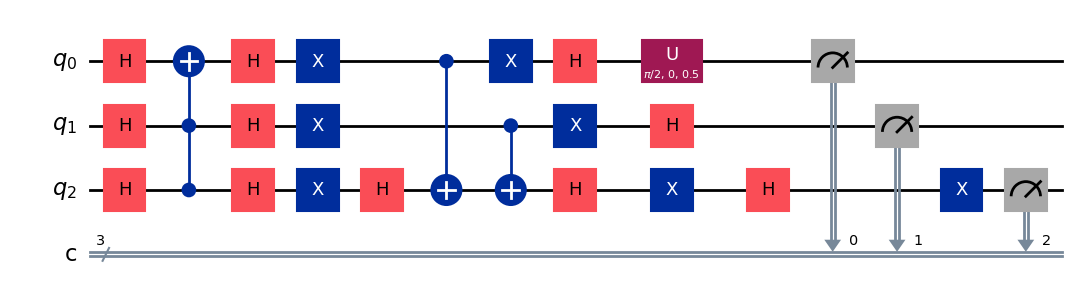

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 45] Best Fitness: 20.5137


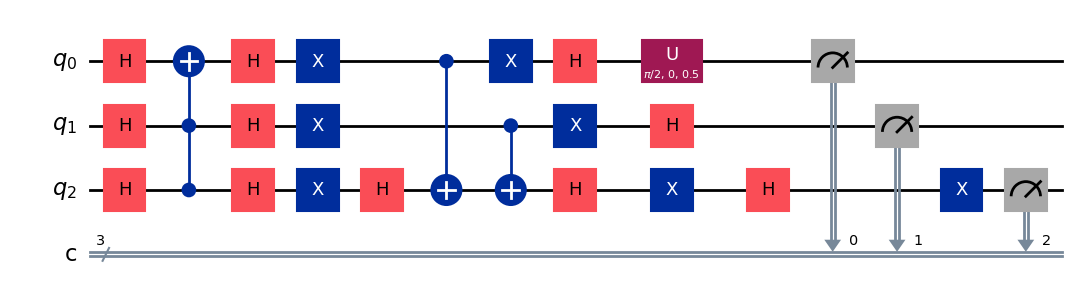

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 46] Best Fitness: 20.5137


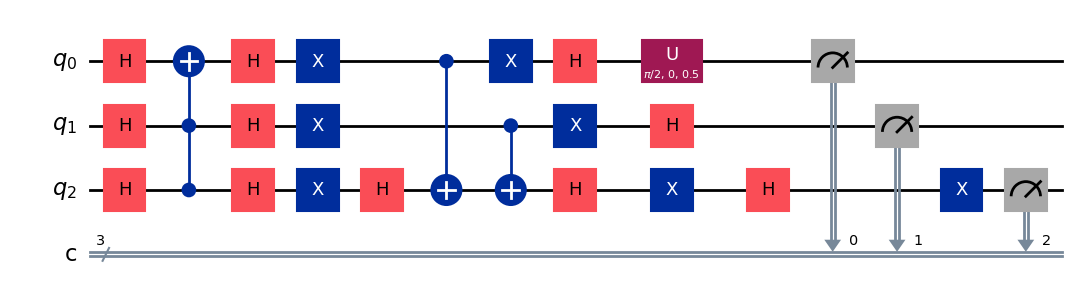

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 47] Best Fitness: 20.5137


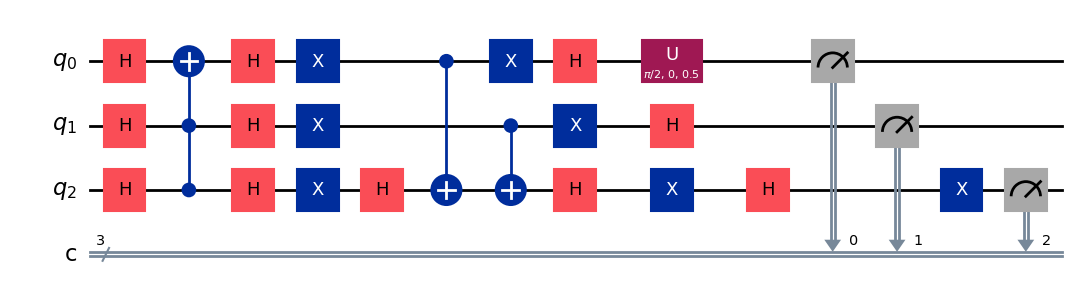

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 48] Best Fitness: 20.5137


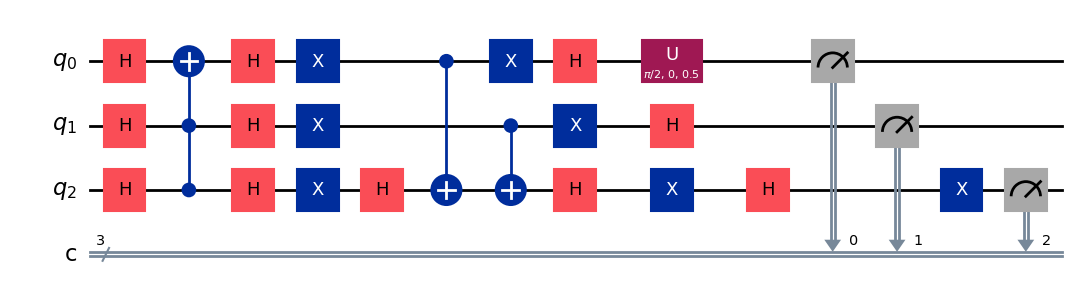

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 49] Best Fitness: 20.5137


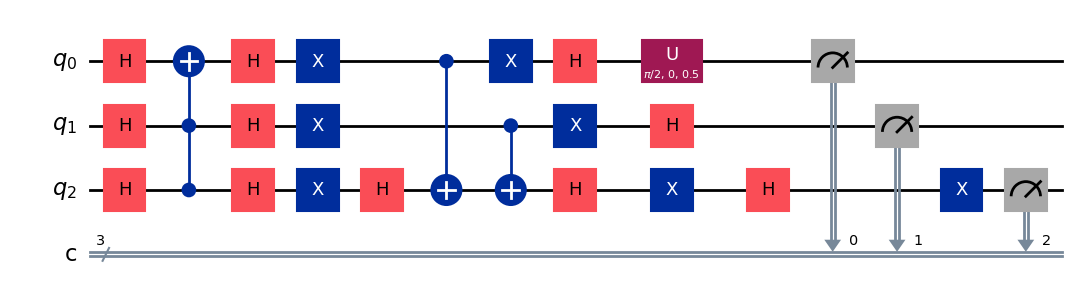

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 50] Best Fitness: 20.5137


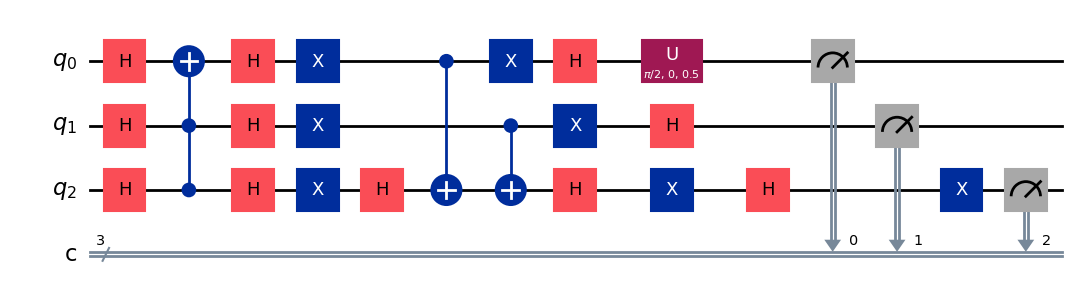

gen = 0 , Best fitness = (20.513671875,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 51] Best Fitness: 20.5137


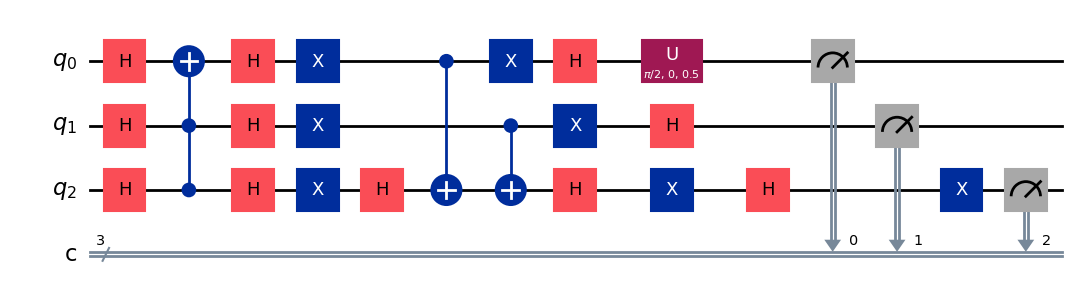

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 52] Best Fitness: 20.5137


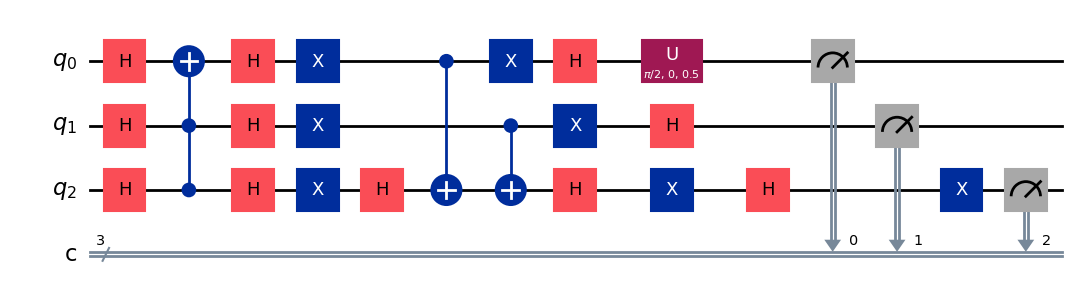

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 53] Best Fitness: 20.5137


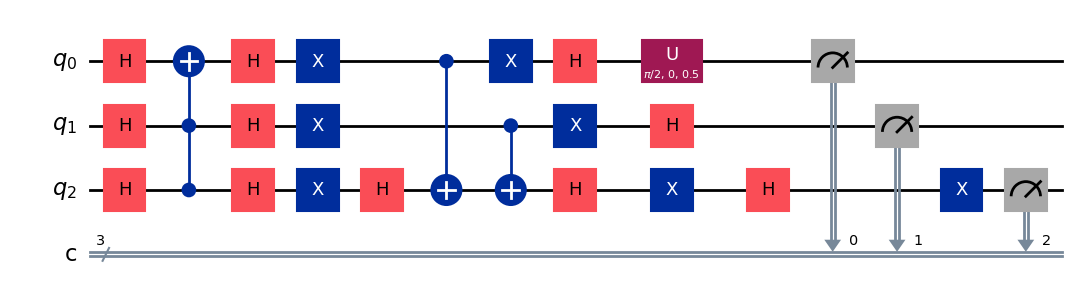

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 54] Best Fitness: 20.5137


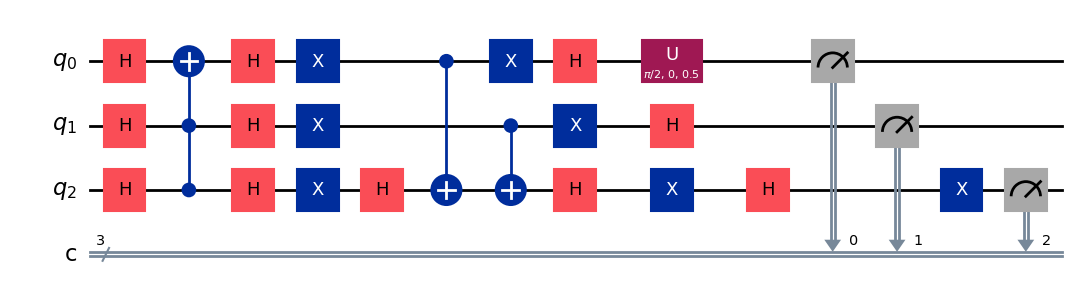

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 55] Best Fitness: 20.5137


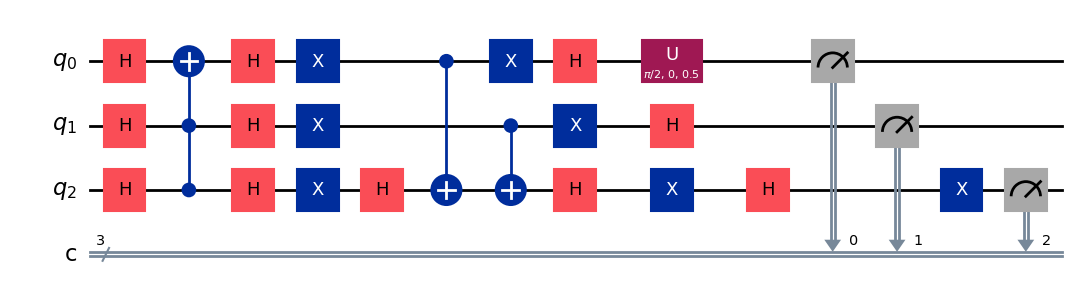

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 56] Best Fitness: 20.5137


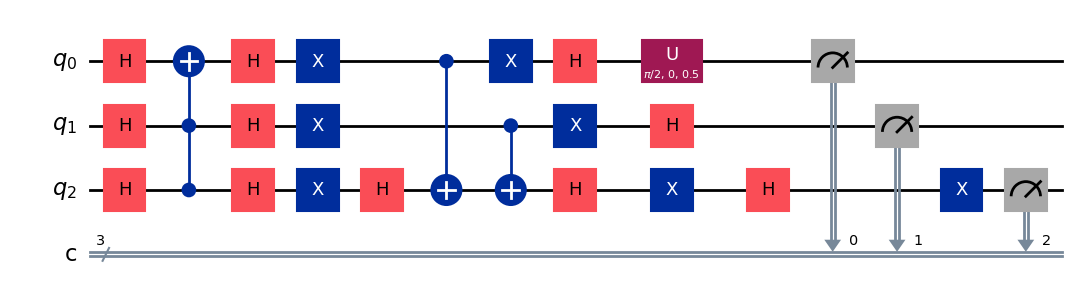

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 57] Best Fitness: 20.5137


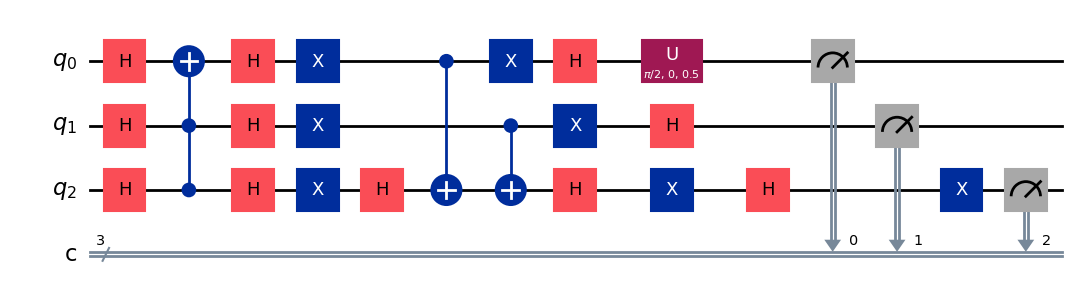

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 58] Best Fitness: 20.5137


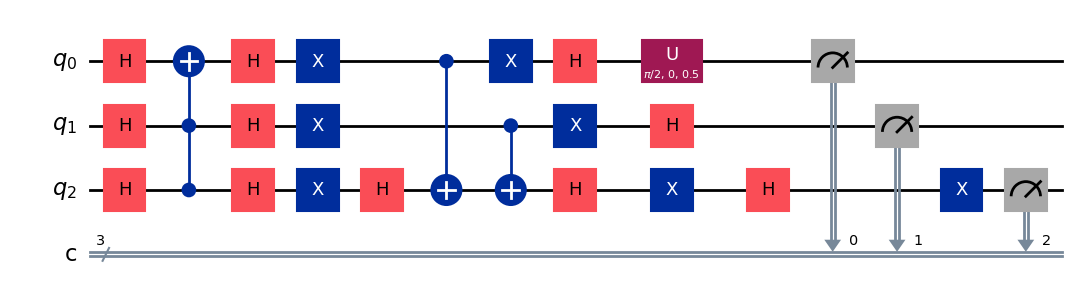

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 59] Best Fitness: 20.5137


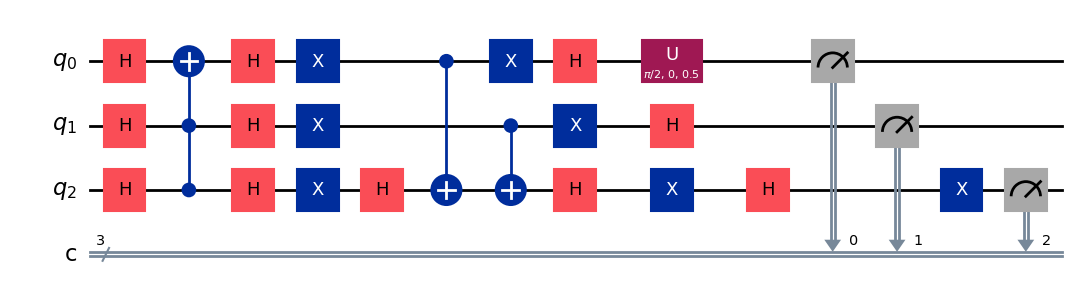

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 60] Best Fitness: 20.5137


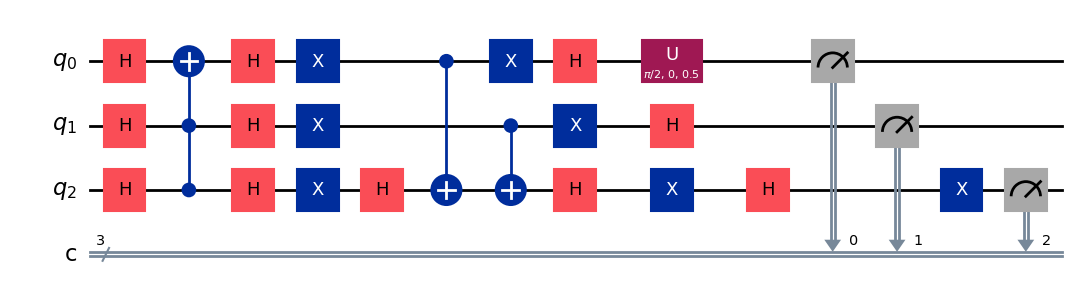

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 61] Best Fitness: 20.5137


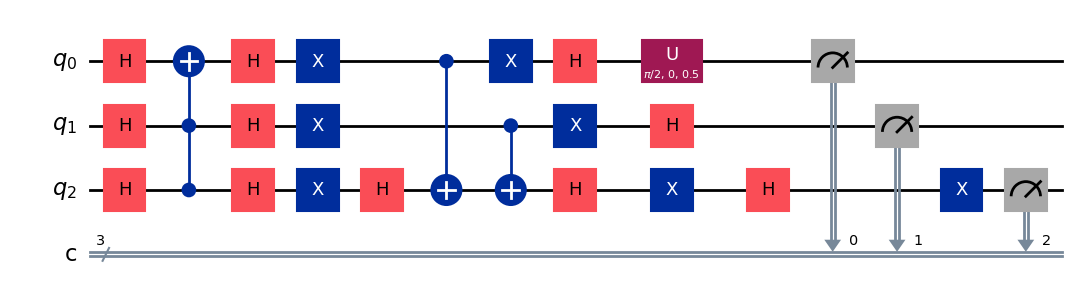

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 62] Best Fitness: 20.5137


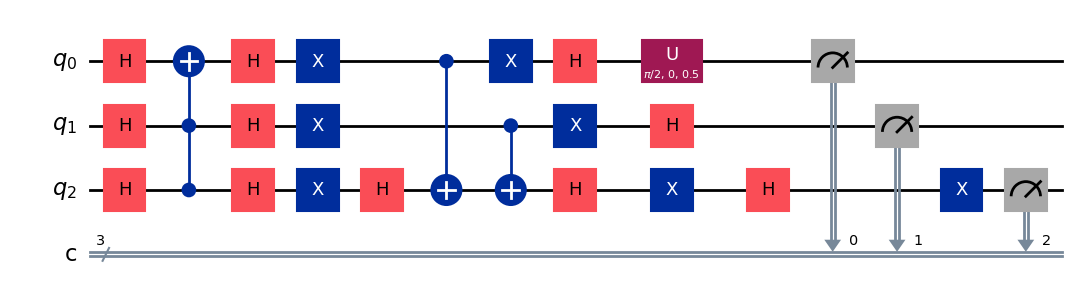

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 63] Best Fitness: 20.5137


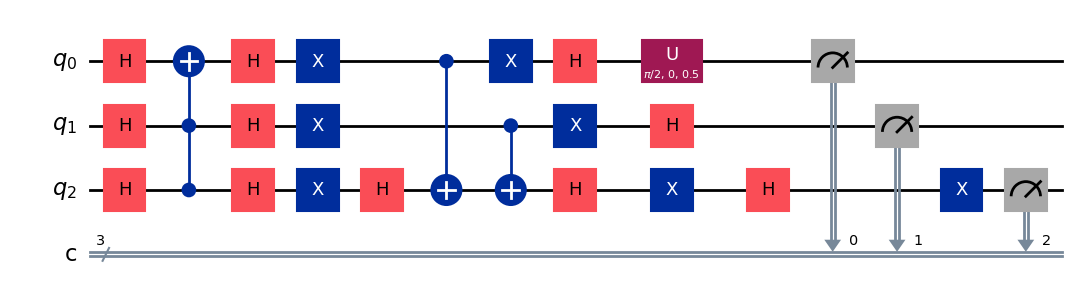

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 64] Best Fitness: 20.5137


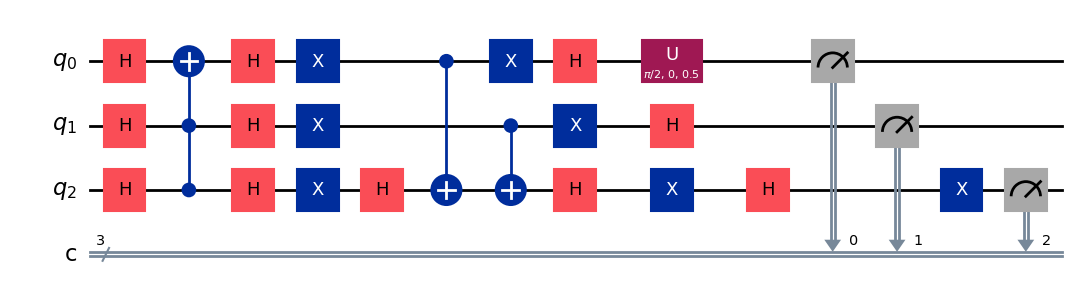

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 65] Best Fitness: 20.5137


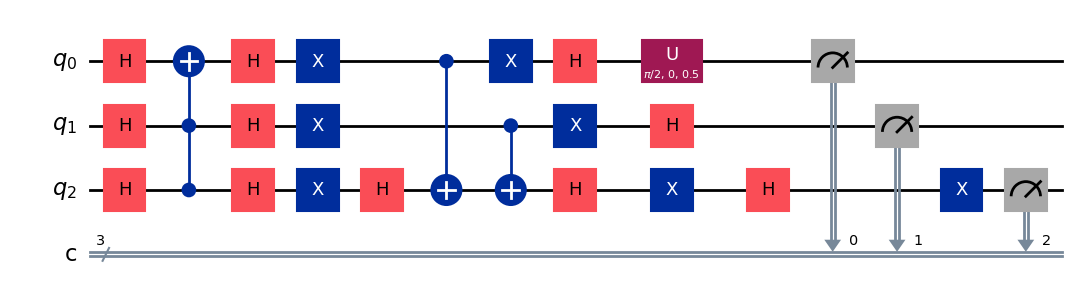

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 66] Best Fitness: 20.5137


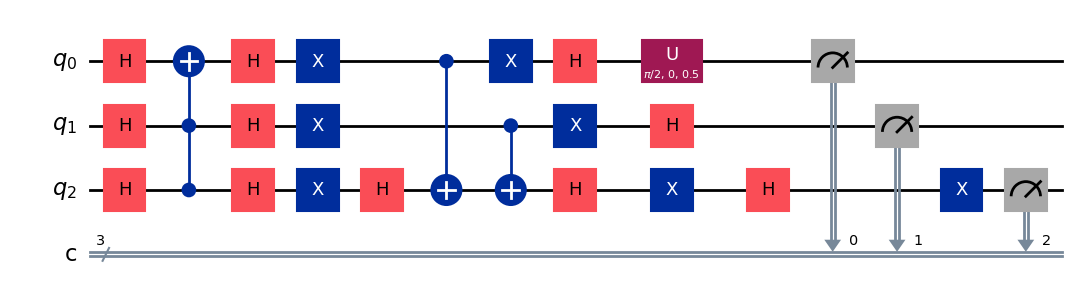

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 67] Best Fitness: 20.5137


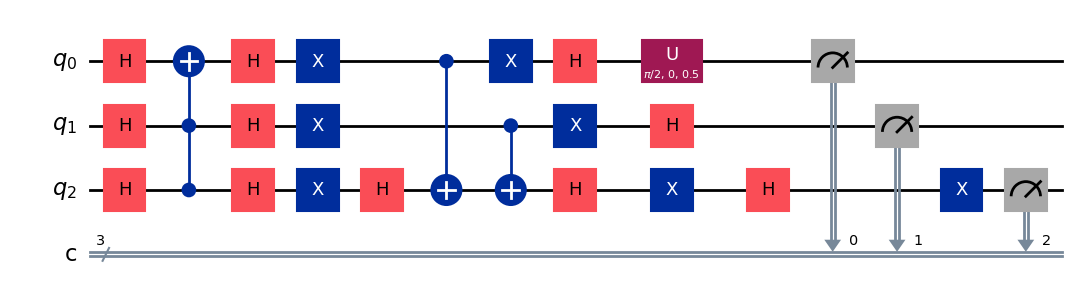

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 68] Best Fitness: 20.5137


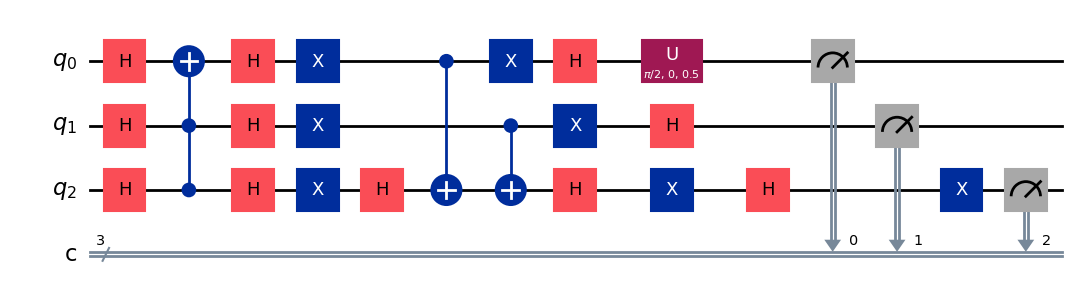

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 69] Best Fitness: 20.5137


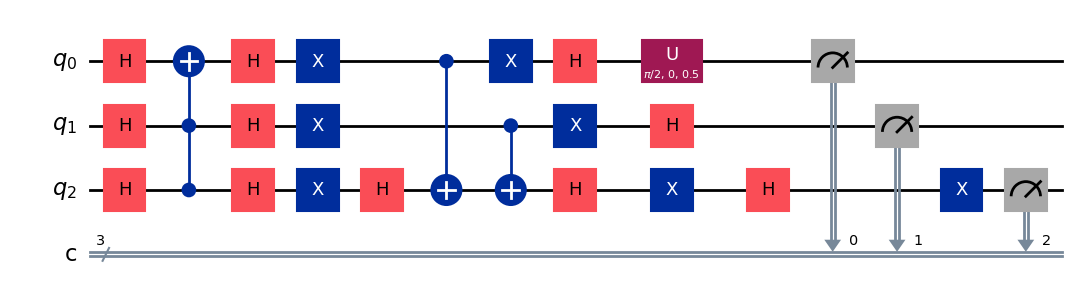

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 70] Best Fitness: 20.5137


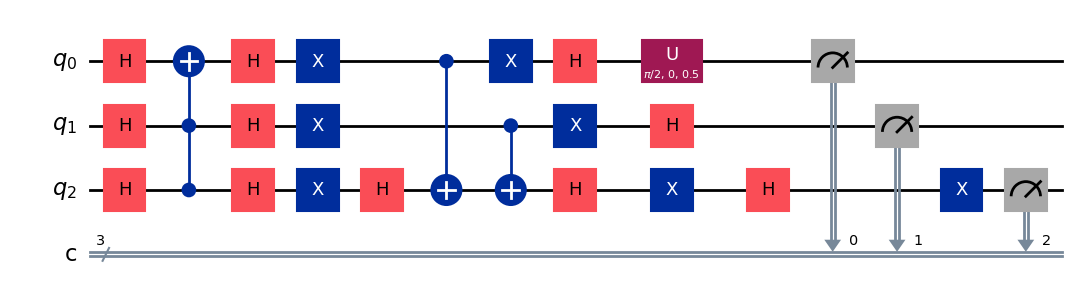

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 71] Best Fitness: 20.5137


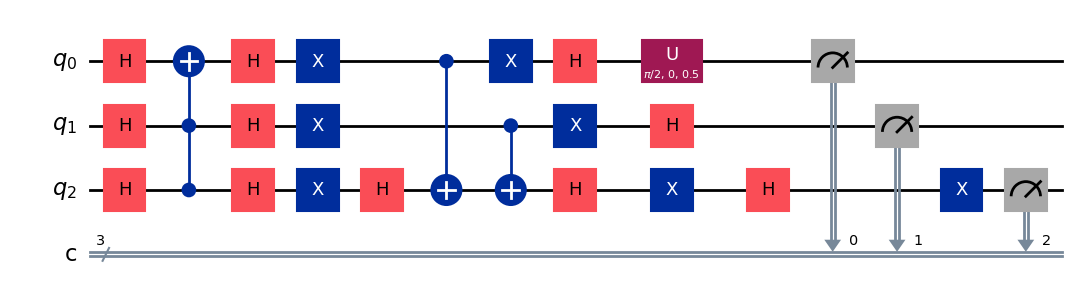

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 72] Best Fitness: 20.5137


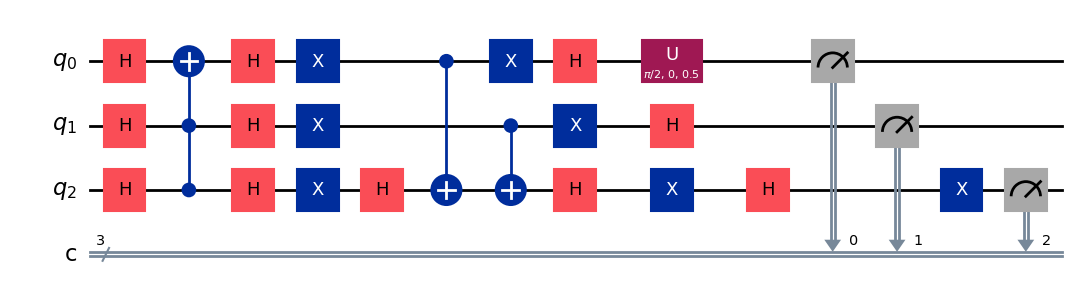

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 73] Best Fitness: 20.5137


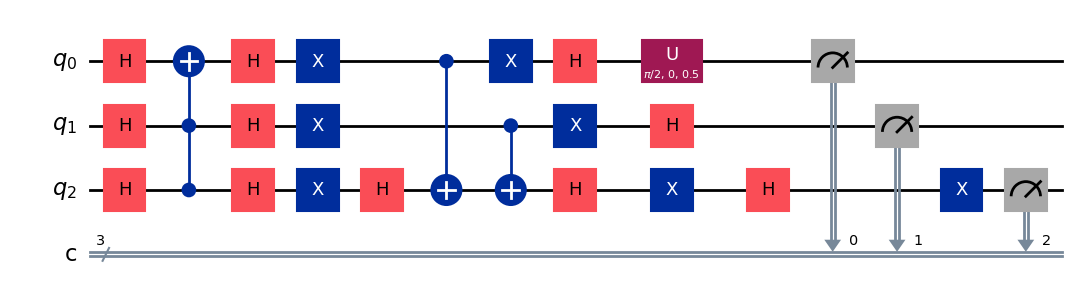

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 74] Best Fitness: 20.5137


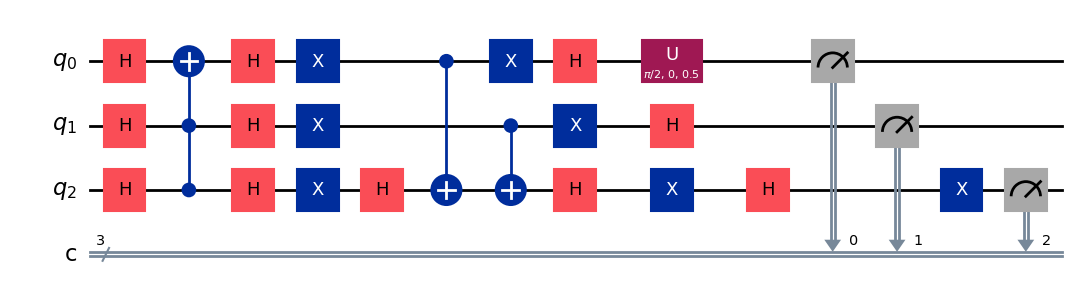

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 75] Best Fitness: 20.5137


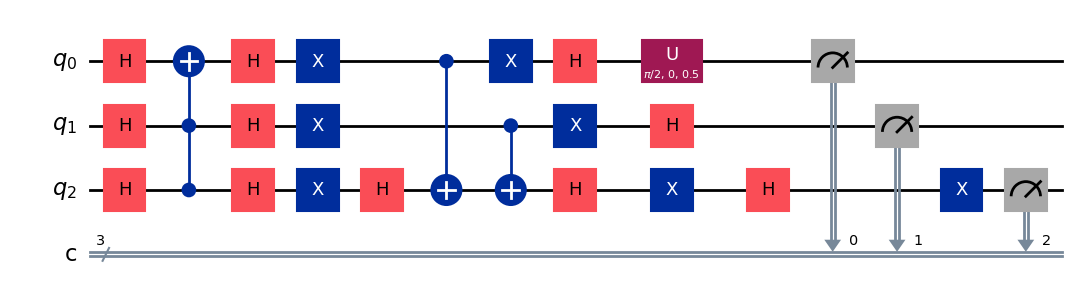

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 76] Best Fitness: 20.5137


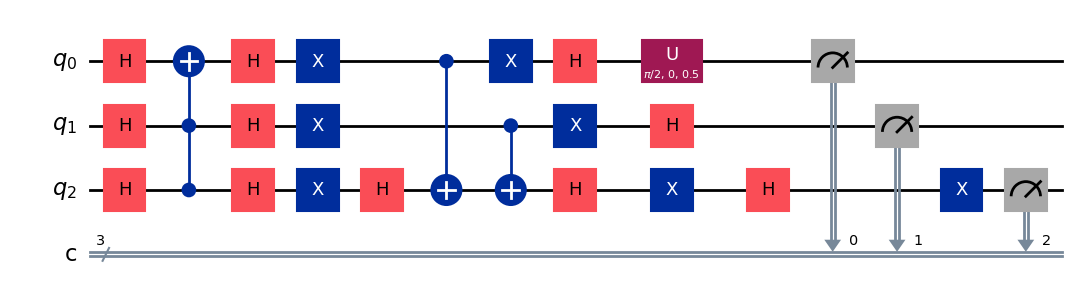

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 77] Best Fitness: 20.5137


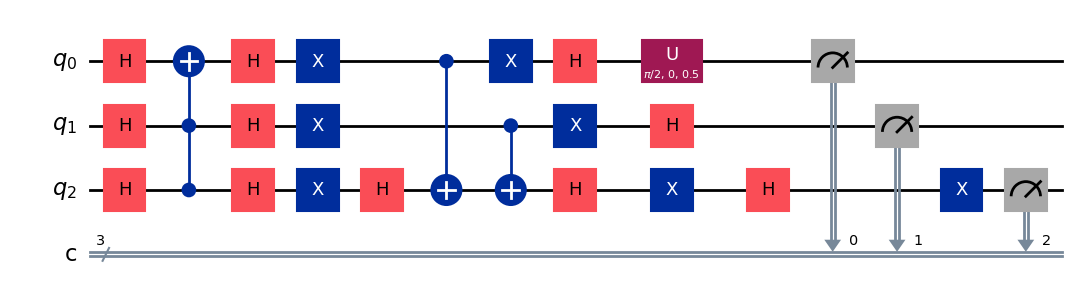

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 78] Best Fitness: 20.5137


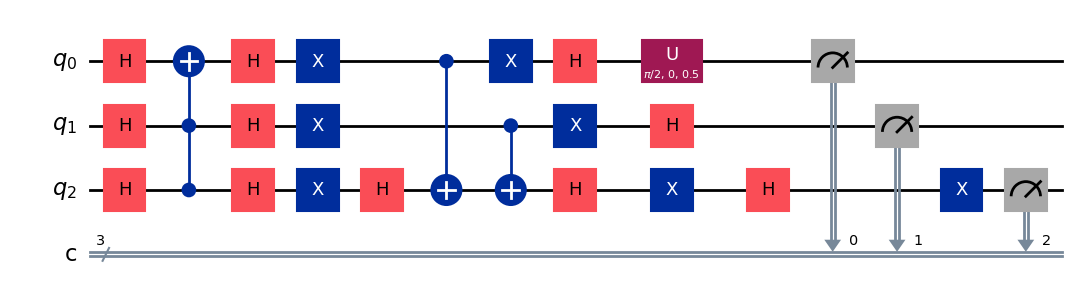

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 79] Best Fitness: 20.5137


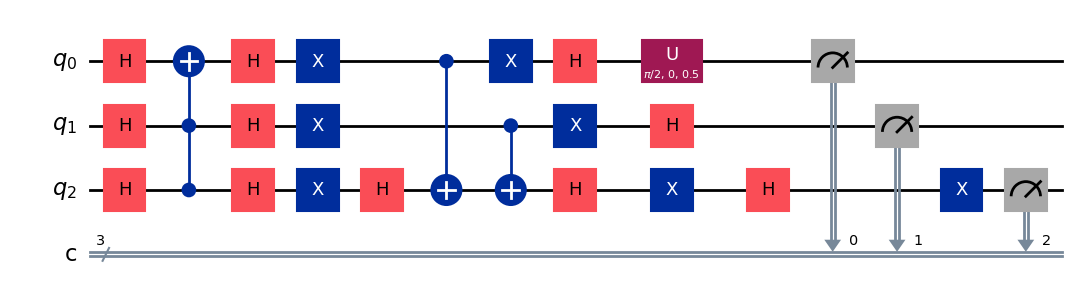

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 80] Best Fitness: 20.5137


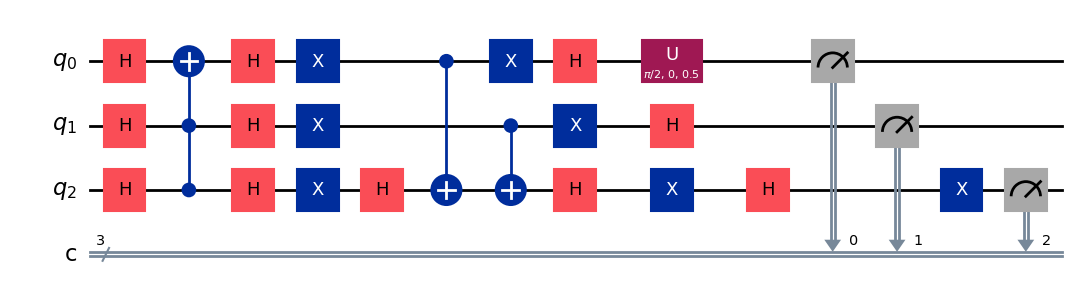

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 81] Best Fitness: 20.5137


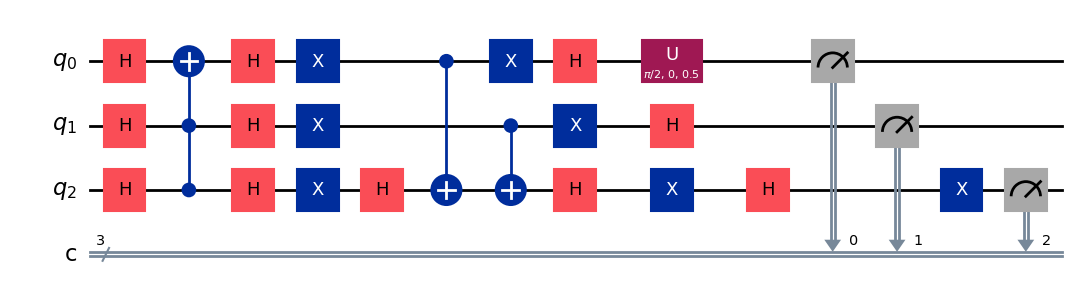

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 82] Best Fitness: 20.5137


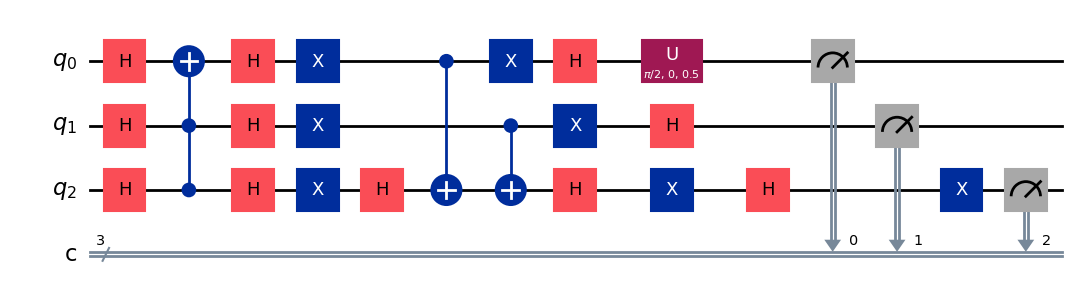

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 83] Best Fitness: 20.5137


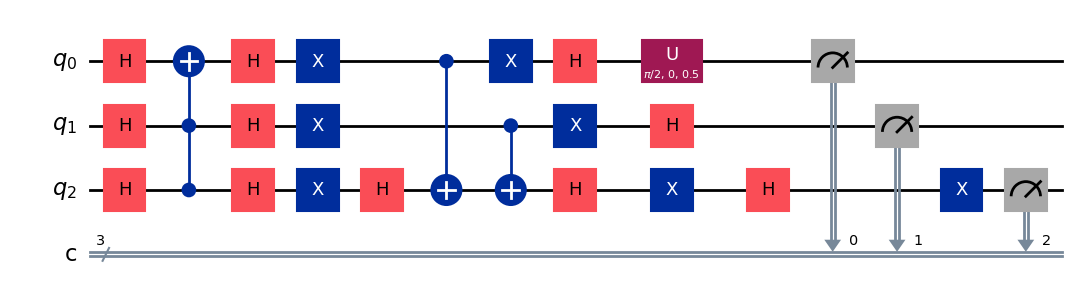

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 84] Best Fitness: 20.5137


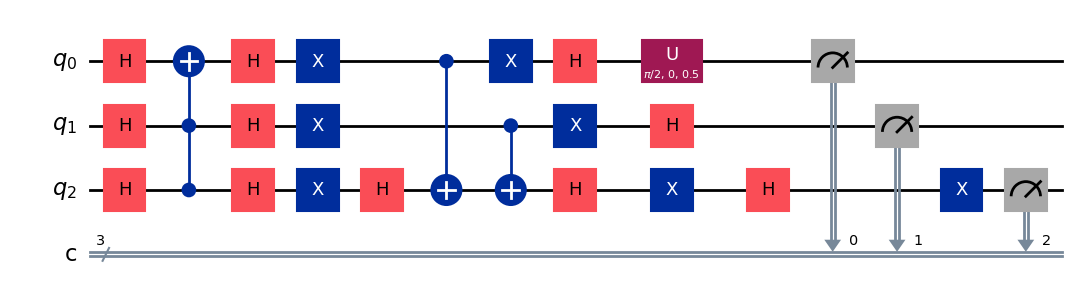

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 85] Best Fitness: 20.5137


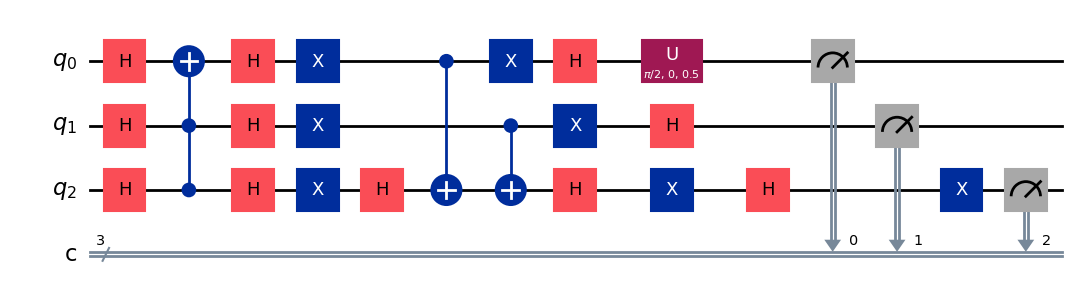

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 86] Best Fitness: 20.5137


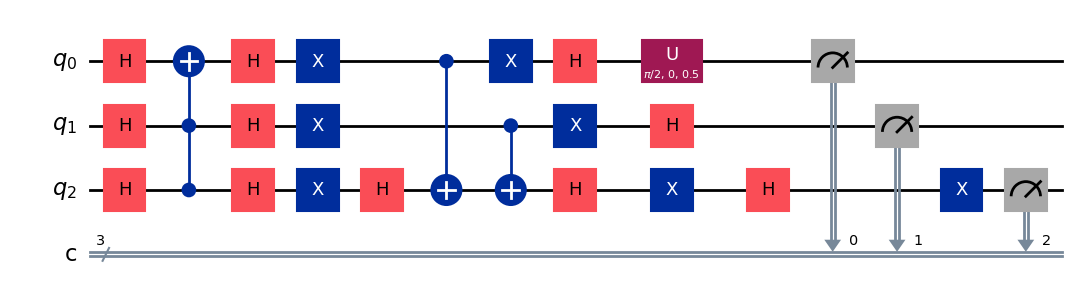

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 87] Best Fitness: 20.5137


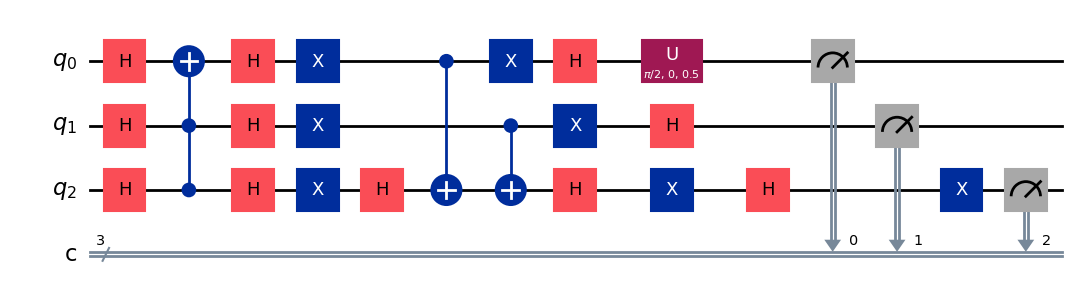

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 88] Best Fitness: 20.5137


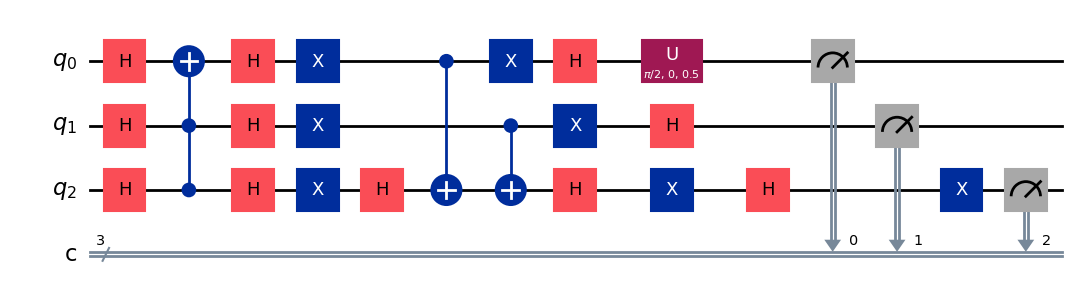

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 89] Best Fitness: 20.5137


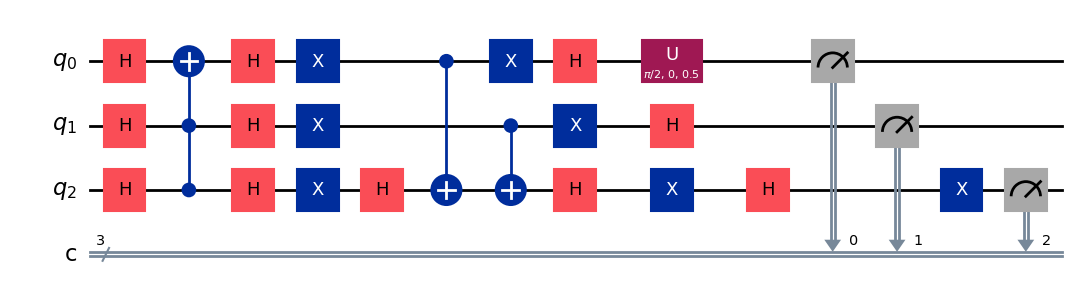

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 90] Best Fitness: 20.5137


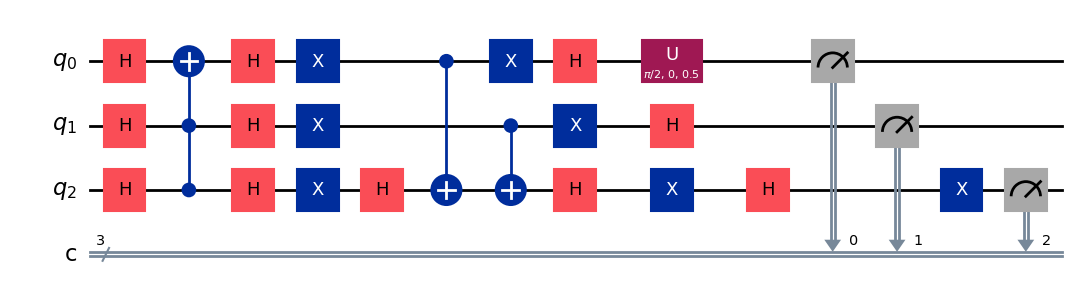

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 91] Best Fitness: 20.5137


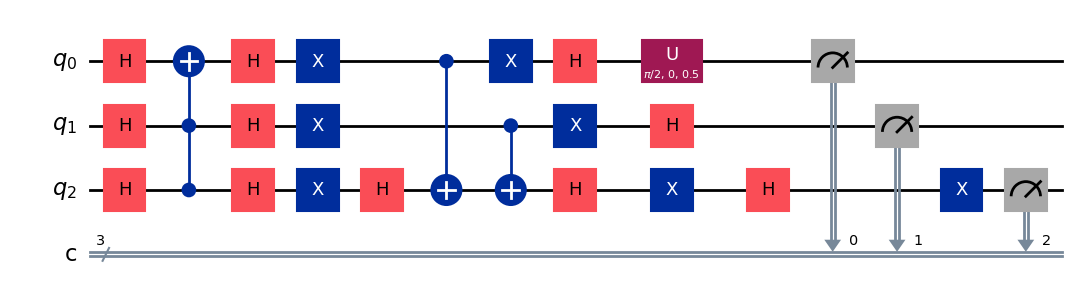

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 92] Best Fitness: 20.5137


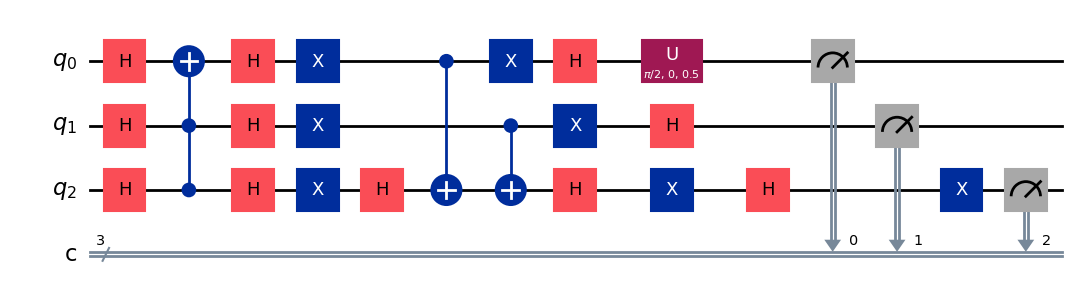

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 93] Best Fitness: 20.5137


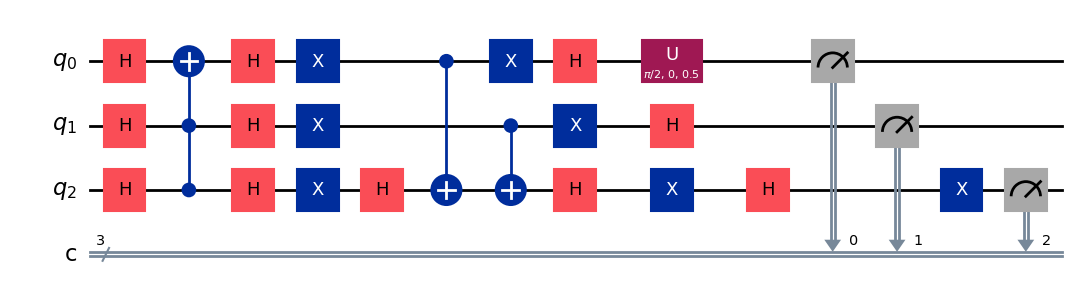

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 94] Best Fitness: 20.5137


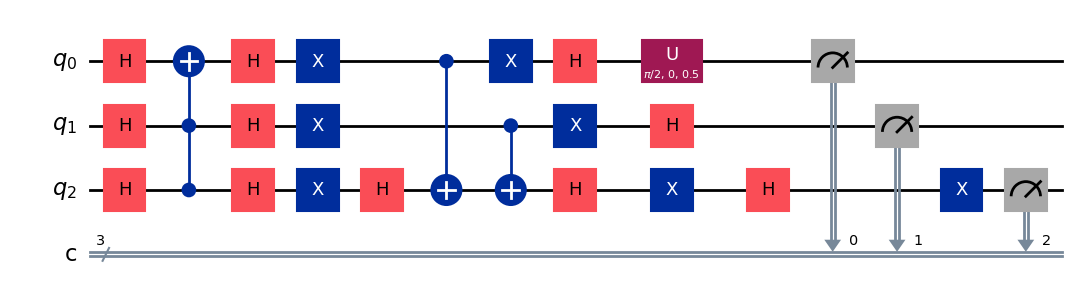

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 95] Best Fitness: 20.5137


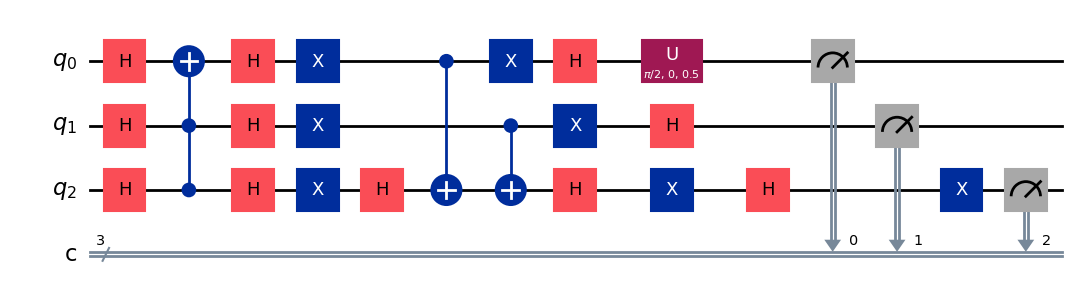

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 96] Best Fitness: 20.5137


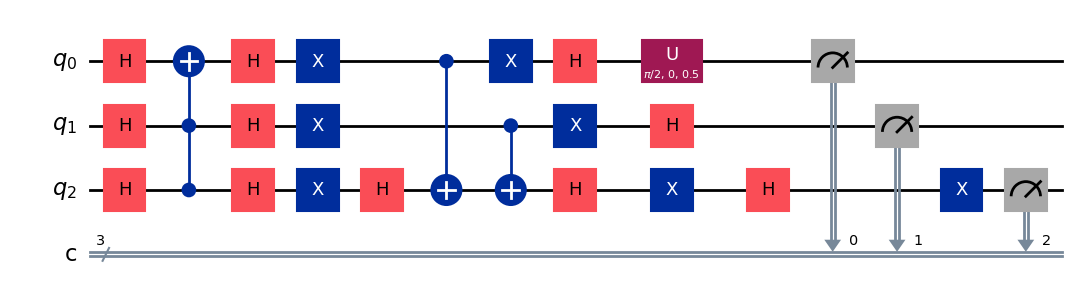

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 97] Best Fitness: 20.5137


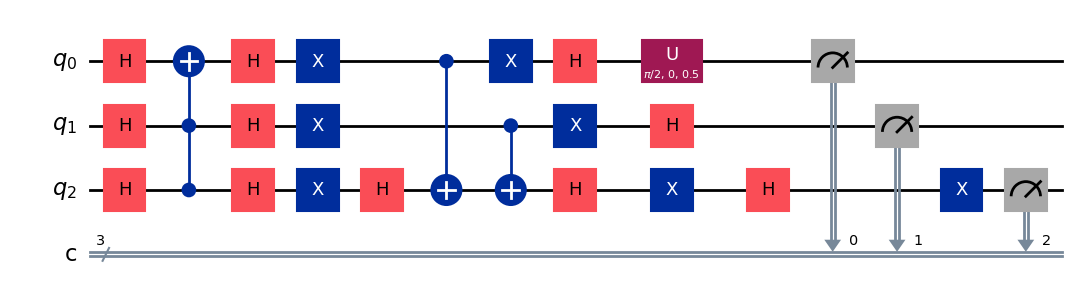

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 98] Best Fitness: 20.5137


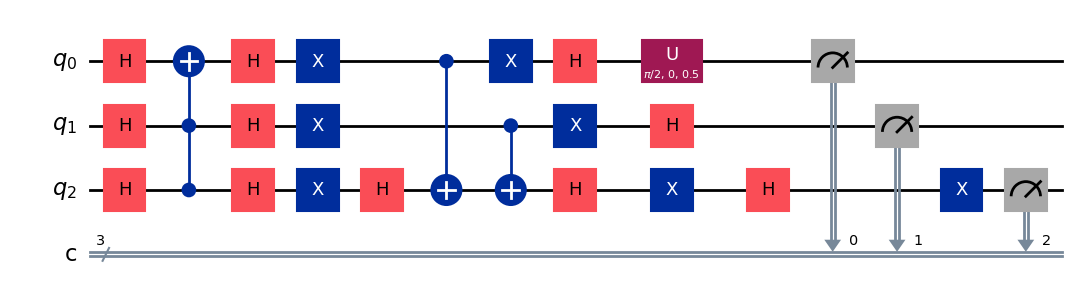

gen = 0 , Best fitness = (20.513671875,)
gen = 1 , Best fitness = (20.513671875,) , Number of invalids = 0

[Generation 99] Best Fitness: 20.5137


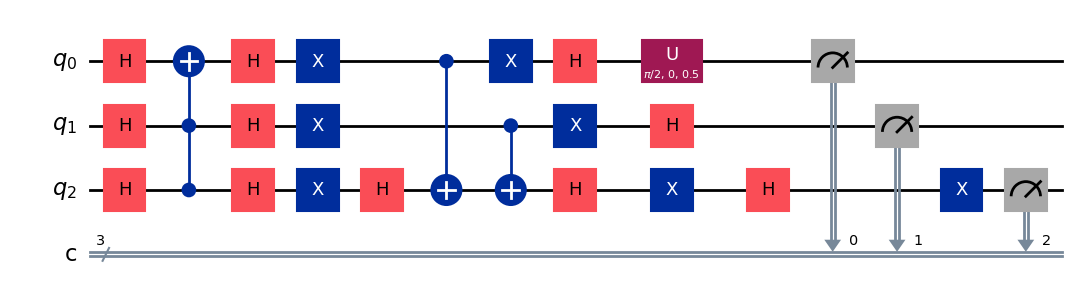

In [13]:
# Create an instance of the evaluator class
evaluator = CircuitEvaluator(shots=512, log_dir=LOG_DIR)

population = toolbox.populationCreator(
    pop_size=POPULATION_SIZE,
    bnf_grammar=BNF_GRAMMAR,
    min_init_depth=MIN_INIT_DEPTH,
    max_init_depth=MAX_INIT_DEPTH,
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION
)
hof = tools.HallOfFame(HALLOFFAME_SIZE)

# Prepare statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Lists to track trends over generations
generations_list = []
best_fitness_list = []
avg_gate_count_list = []

# Run the GE evolutionary algorithm with elitism
for gen in range(MAX_GENERATIONS):
    population, logbook = algorithms.ge_eaSimpleWithElitism(
        population,
        toolbox,
        cxpb=P_CROSSOVER,
        mutpb=P_MUTATION,
        ngen=N_GEN,
        elite_size=ELITE_SIZE,
        bnf_grammar=BNF_GRAMMAR,
        codon_size=CODON_SIZE,
        max_tree_depth=MAX_TREE_DEPTH,
        codon_consumption=CODON_CONSUMPTION,
        report_items=REPORT_ITEMS,
        genome_representation=GENOME_REPRESENTATION,
        stats=stats,
        halloffame=hof,
        verbose=False
    )

    best_ind = tools.selBest(population, 1)[0]
    best_ind.generation = gen  # for logging

    # Evaluate the best individual to extract additional metrics
    best_phenotype = evaluator.decode_individual(best_ind)
    if best_phenotype is not None:
        fitness_val, logs = fitness_function(best_phenotype, log_states=True)
        best_fitness_list.append(fitness_val)
        # Calculate average gate count from logs (if available)
        if logs:
            avg_gate = np.mean([log["gate_count"] for log in logs])
        else:
            avg_gate = 0
        avg_gate_count_list.append(avg_gate)
        generations_list.append(gen)

    # Optional: visualize best circuit
    qc = evaluator.execute_circuit(best_phenotype)
    if qc:
        print(f"\n[Generation {gen}] Best Fitness: {best_ind.fitness.values[0]:.4f}")
        display(qc.draw("mpl"))
pool.close()
pool.join()

## 10. Final Evaluation and Visualization

In the final section, we:
- Display the best individuals from the Hall of Fame.
- Visualize the quantum circuits, their measurement histograms, and the evolution of fitness over generations.
- Plot the success probability heatmap across all marked states.


[HALL OF FAME]
Individual 1:
Genome: [271, 144, 366, 106, 74, 299, 175, 341, 374, 188, 324, 176, 8, 66, 344, 39, 331, 218, 384, 78, 147, 66, 302, 33, 143, 173, 188, 252, 137, 88, 17, 303, 9, 69, 339, 18, 265, 385, 30, 98, 151, 134, 3, 356, 344, 32, 375, 115, 334, 93, 70, 91, 225, 131, 185, 185, 136, 93, 397, 347, 98, 37, 255, 37, 239, 242, 80, 355, 289, 123, 337, 136, 247, 189, 39, 21, 228, 116, 91, 147, 85, 149, 359, 327, 144, 154, 143, 393, 355, 175, 140, 154, 43, 286, 80, 306, 49, 336, 357, 68, 124, 237, 9, 299, 168, 281, 83, 45, 95, 39, 345, 93, 208, 87, 274, 126, 395, 198, 195, 326, 218, 342, 310, 364, 345, 205, 90, 27, 7, 291, 49, 73, 358, 299, 236, 208, 317, 174, 50, 252, 386, 337, 34, 118, 267, 365, 268, 241, 312, 17, 267, 329, 400, 75, 6, 322, 140, 40, 315, 350, 280, 46, 301, 324, 290, 160, 371, 361, 91, 177, 247, 157, 172, 181]
Phenotype: "qc = QuantumCircuit(3, 3)\n" "qc.h(0)\n" "qc.h(1)\n" "qc.h(2)\n" "## Begin Oracle\n" "qc.ccx(" "2,1,0" ")\n" "## End Oracle\n" "## Begin 

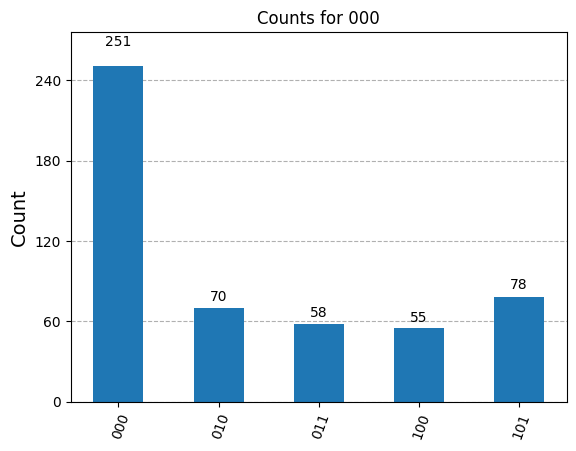

Marked State: 001
Oracle:
qc.x(0)
qc.x(1)
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)
qc.x(0)
qc.x(1)

p(marked): 0.4922, error: 0.5078
Gate Count: 37


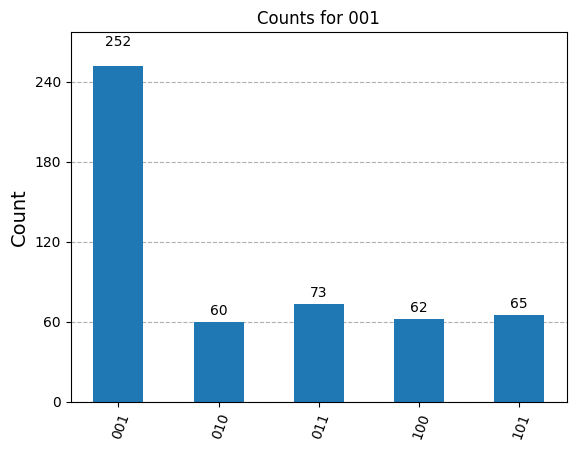

Marked State: 010
Oracle:
qc.x(0)
qc.x(2)
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)
qc.x(0)
qc.x(2)

p(marked): 0.4961, error: 0.5039
Gate Count: 37


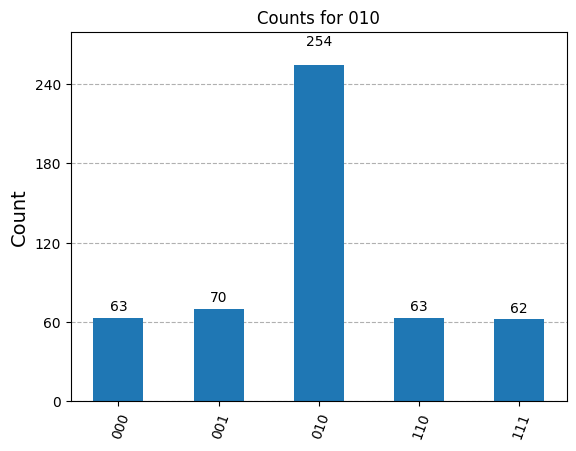

Marked State: 011
Oracle:
qc.x(0)
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)
qc.x(0)

p(marked): 0.5039, error: 0.4961
Gate Count: 33


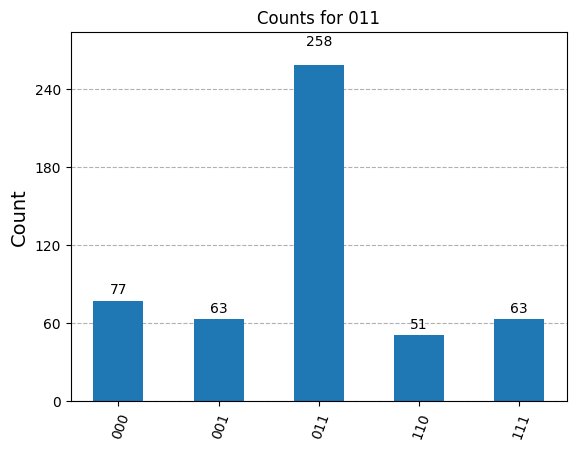

Marked State: 100
Oracle:
qc.x(1)
qc.x(2)
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)
qc.x(1)
qc.x(2)

p(marked): 0.4922, error: 0.5078
Gate Count: 37


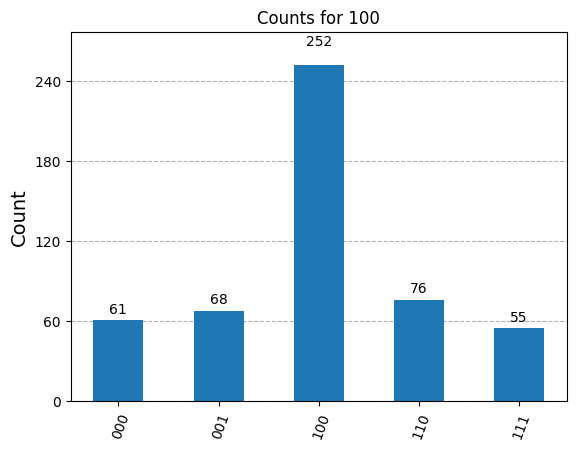

Marked State: 101
Oracle:
qc.x(1)
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)
qc.x(1)

p(marked): 0.4180, error: 0.5820
Gate Count: 33


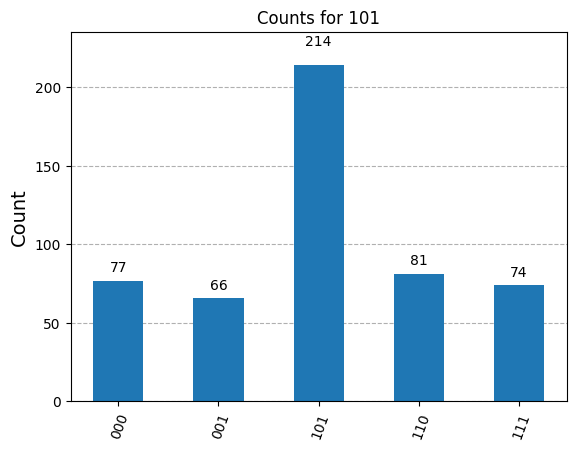

Marked State: 110
Oracle:
qc.x(2)
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)
qc.x(2)

p(marked): 0.4980, error: 0.5020
Gate Count: 33


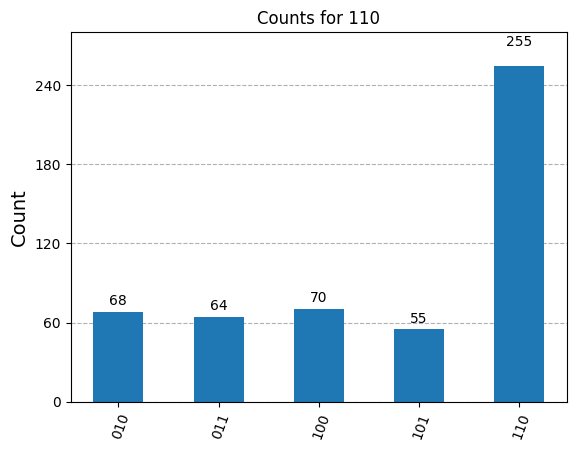

Marked State: 111
Oracle:
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)

p(marked): 0.5000, error: 0.5000
Gate Count: 29


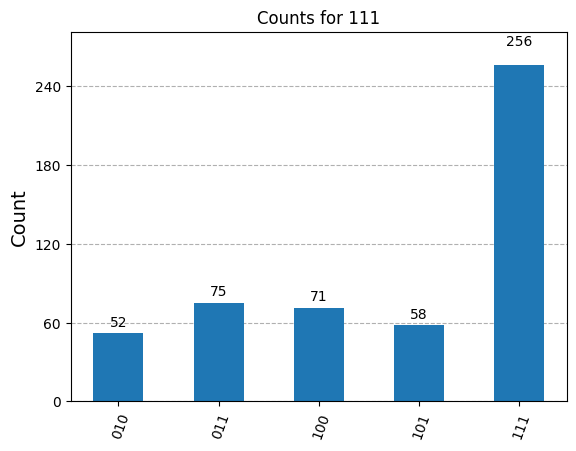

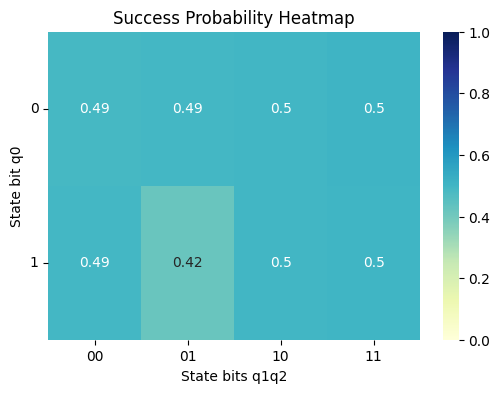

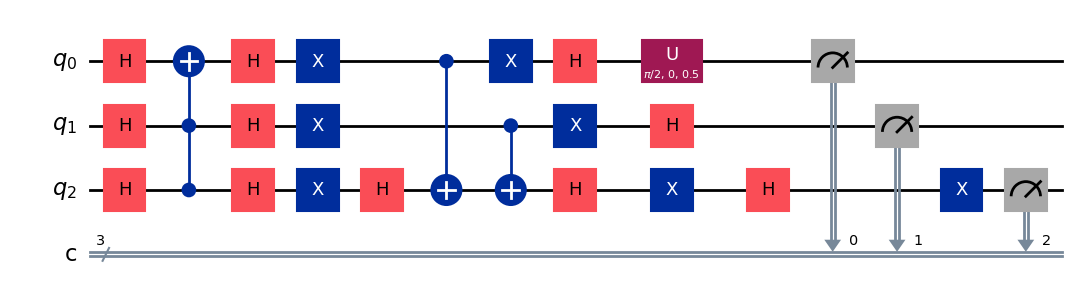


Best Individual's Fitness: 20.513671875


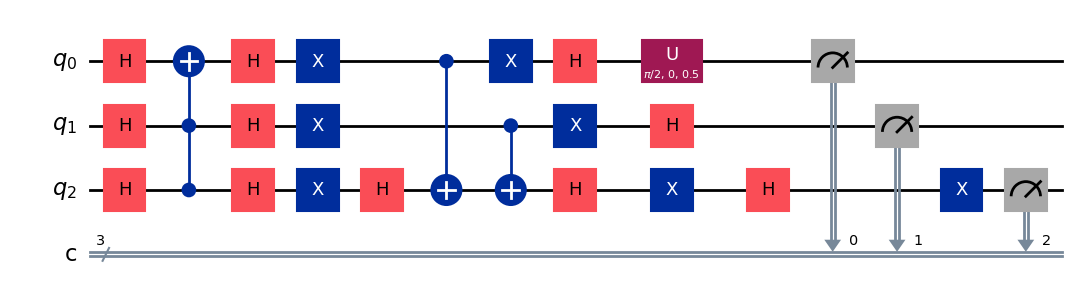

In [14]:
print("\n[HALL OF FAME]")
for i, hof_ind in enumerate(hof.items):
    print(f"Individual {i+1}:")
    print(f"Genome: {hof_ind.genome}")
    print(f"Phenotype: {hof_ind.phenotype}")
    print(f"Fitness: {hof_ind.fitness.values[0]}")

# Decode and display the best circuit from the Hall of Fame
best_ind = hof.items[0]
best_phenotype = evaluator.decode_individual(best_ind)
phenotype = evaluator.decode_individual(best_ind)
fitness, log_per_state = fitness_function(phenotype, log_states=True)

for log in log_per_state:
    print(f"Marked State: {log['state']}")
    print(f"Oracle:\n{log['oracle']}")
    print(f"p(marked): {log['p_marked']:.4f}, error: {log['error']:.4f}")
    print(f"Gate Count: {log['gate_count']}")
    display(plot_histogram(log["counts"], title=f"Counts for {log['state']}"))

# Visualize performance across all marked states
plot_success_heatmap(log_per_state)

# Convert the phenotype code string into an actual QuantumCircuit.
best_circuit = evaluator.execute_circuit(best_phenotype)
if best_circuit:
    display(best_circuit.draw("mpl"))  # Display the circuit diagram
else:
    print("The best individual could not be decoded into a valid circuit.")

print("\nBest Individual's Fitness:", best_ind.fitness.values[0])

# Convert and simulate the best circuit.
best_phenotype = evaluator.decode_individual(best_ind)
best_circuit = evaluator.execute_circuit(best_phenotype)
if best_circuit:
    display(best_circuit.draw('mpl'))
    simulator = QasmSimulator()
    compiled_circuit = transpile(best_circuit, simulator)
    result = simulator.run(compiled_circuit, shots=512).result()
    counts = result.get_counts()
    corrected_counts = {k[::-1]: v for k, v in counts.items()}  # Reverse bitstrings
    # Optionally, display histogram of measurement counts:
    # display(plot_histogram(corrected_counts, title="Measurement Counts for Best Individual"))
else:
    print("Best individual could not be decoded into a valid circuit.")

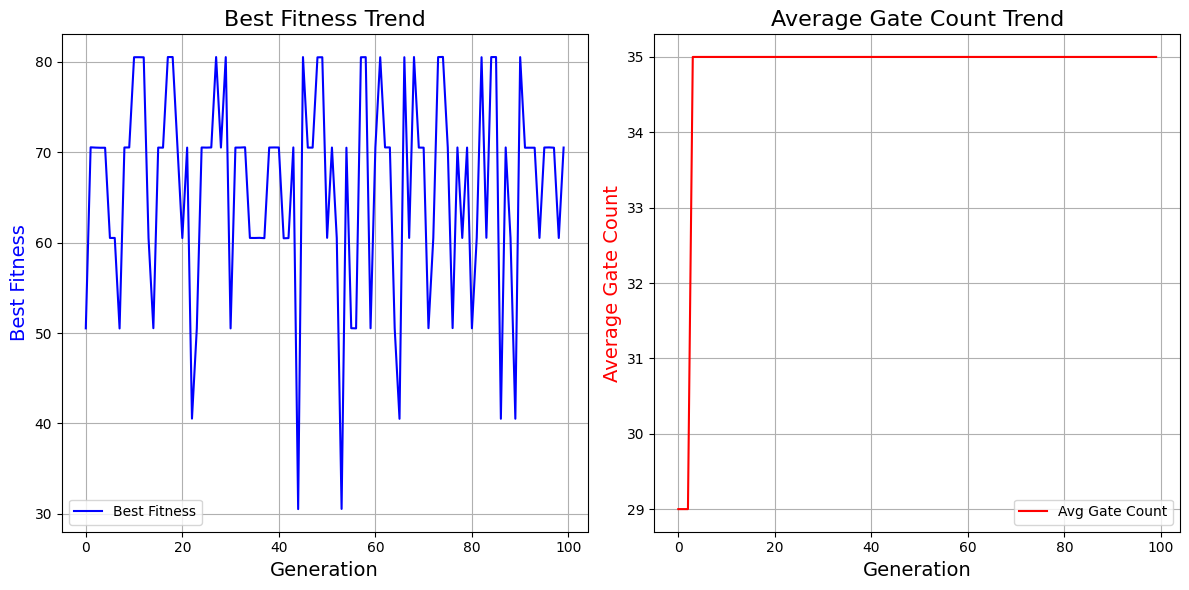

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Plot Best Fitness on the left subplot
ax1.plot(generations_list, best_fitness_list, 'b-', label='Best Fitness')
ax1.set_xlabel('Generation', fontsize=14)
ax1.set_ylabel('Best Fitness', color='b', fontsize=14)
ax1.set_title('Best Fitness Trend', fontsize=16)
ax1.grid(True)
ax1.legend()

# Plot Average Gate Count on the right subplot
ax2.plot(generations_list, avg_gate_count_list, 'r-', label='Avg Gate Count')
ax2.set_xlabel('Generation', fontsize=14)
ax2.set_ylabel('Average Gate Count', color='r', fontsize=14)
ax2.set_title('Average Gate Count Trend', fontsize=16)
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()